<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Example Implementation of GRHayL: Replicating the IllinoisGRMHD code using GRHayL

## Author: Terrence Pierre Jacques
### Formatting improvements courtesy Brandon Clark

## This notebook will utilize the General Relativistic Hydrodynamic Library (GRHayL) to recreate the results of the IllinoisGRMHD code, for a suite of GRMHD shock tests.

**Notebook Status:** <font color ="red"><b> Not validated </b></font>

<!-- **Validation Notes:** This module has been validated to converge at the expected order to the exact solution (see [plot](#convergence) at bottom). -->

<!-- ### NRPy+ Source Code for this module: 
* [ScalarWave/ScalarWaveCurvilinear_RHSs.py](../edit/ScalarWave/ScalarWaveCurvilinear_RHSs.py) [\[**tutorial**\]](Tutorial-ScalarWaveCurvilinear.ipynb) Generates the right-hand side for the Scalar Wave Equation in curvilinear coordinates
* [ScalarWave/InitialData.py](../edit/ScalarWave/InitialData.py) [\[**tutorial**\]](Tutorial-ScalarWave.ipynb) Generating C code for either plane wave or spherical Gaussian initial data for the scalar wave equation  -->

## Introduction:
GRHayL is code base that aims to provide robust and well tested codes for evolving relativistic fluids. Towards this end, GRHayL currently supports reconstruction, flux/source term calculations, hybrid and tabulated equations of state, and conservative-to-primitive solvers

The entire algorithm is outlined below, with NRPy+-based components highlighted in <font color='green'>green</font>.

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. <font color='green'>Set gridfunction values to initial data.</font>
1. Evolve the system forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. <font color='green'>GRMHD RHS expressions.</font>
    1. Apply conservatives-to-primitives routines
    1. Apply boundary conditions.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#writec): Generate C code to solve the scalar wave equation in curvilinear coordinates
    1. [Step 1.a](#id_rhss): C code generation: Initial data and scalar wave right-hand-sides
    1. [Step 1.b](#OuterBoundaryConditions): C code generation: Boundary condition driver
    1. [Step 1.c](#cparams_rfm_and_domainsize): Generate Cparameters files; set reference metric parameters, including `domain_size`
    1. [Step 1.d](#cfl): C code generation: Finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep
1. [Step 2](#mainc): The C code `main()` function for `ScalarWaveCurvilinear_Playground`
1. [Step 3](#compileexec): Compile generated C codes & solve the scalar wave equation
1. [Step 4](#convergence): Code validation: Plot the numerical error, and confirm that it converges to zero at expected rate with increasing numerical resolution (sampling)
1. [Step 5](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='writec'></a>

# Step 1: Using NRPy+ to generate necessary C codes to supplement codes in GRHayL to solve the equations of GRMHD \[Back to [top](#toc)\]
$$\label{writec}$$

<a id='id_rhss'></a>

## Step 1.a: C code generation: Initial data and GRMHD RHSs \[Back to [top](#toc)\]
$$\label{id_rhss}$$

To evolve the GRMHD equations in time, we need to specify initial data, that we may march forward using the method of lines approach (MoL), and right-hand-sides (RHSs) to dictate how these data are evolved. 

We begin by importing some key NRPy+ python modules. We then construct C codes to supply initial data to our grid functions. These initial data are 1D and 2D shock tests, and all options are compiled so that at run time we may choose which initial data set we wish to evolve test. The tests ar stored in the ShockTests directory within NRPy+.

In [1]:
import shutil, os, sys                # Standard Python modules for multiplatform OS-level functions
nrpy_dir_path = os.path.join("../../GRHayL/Flux_Source/nrpy")
if nrpy_dir_path not in sys.path:
    sys.path.append(nrpy_dir_path)
    
    # Step P1: Import needed NRPy+ core modules:
from outputC import lhrh, outCfunction, add_to_Cfunction_dict  # NRPy+: Core C code output module
import finite_difference as fin       # NRPy+: Finite difference C code generation module
import NRPy_param_funcs as par        # NRPy+: Parameter interface
import grid as gri                    # NRPy+: Functions having to do with numerical grids
import reference_metric as rfm        # NRPy+: Reference metric support
import indexedexp as ixp         # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import cmdline_helper as cmd          # NRPy+: Multi-platform Python command-line interface
import sympy as sp

# Step P2: Create C code output directory:
Ccodesrootdir = os.path.join("GRHayL_NRPy_IGM_Ccodes")
# First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
shutil.rmtree(Ccodesrootdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(Ccodesrootdir)

# Step P3: Create executable output directory:
outdir = os.path.join(Ccodesrootdir, "output")
cmd.mkdir(outdir)

# Step P4: Enable/disable SIMD. If enabled, code should run ~2x faster on most CPUs.
enable_SIMD = True

# Step P5: Enable reference metric precomputation.
enable_rfm_precompute = False
if enable_rfm_precompute:
    par.set_parval_from_str("reference_metric::rfm_precompute_to_Cfunctions_and_NRPy_basic_defines", "True")
else:
    par.set_parval_from_str("reference_metric::rfm_precompute_to_Cfunctions_and_NRPy_basic_defines", "False")

# if enable_SIMD and not enable_rfm_precompute:
#     print("ERROR: SIMD does not currently handle transcendental functions,\n")
#     print("       like those found in rfmstruct (rfm_precompute).\n")
#     print("       Therefore, enable_SIMD==True and enable_rfm_precompute==False\n")
#     print("       is not supported.\n")
#     sys.exit(1)

# Step P6: Enable "FD functions". In other words, all finite-difference stencils
#         will be output as inlined static functions. This is essential for
#         compiling highly complex FD kernels with using certain versions of GCC;
#         GCC 10-ish will choke on BSSN FD kernels at high FD order, sometimes
#         taking *hours* to compile. Unaffected GCC versions compile these kernels
#         in seconds. FD functions do not slow the code performance, but do add
#         another header file to the C source tree.
# With gcc 7.5.0, enable_FD_functions=True decreases performance by 10%
enable_FD_functions = False

# Step 1: Set some core parameters, including CoordSystem, boundary condition,
#                                             MoL, timestepping algorithm, FD order,
#                                             floating point precision, and CFL factor:

# Step 1.a: Set the coordinate system for the numerical grid
# Choices are: Spherical, SinhSpherical, SinhSphericalv2, Cylindrical, SinhCylindrical,
#              SymTP, SinhSymTP
CoordSystem     = "Cartesian"
par.set_parval_from_str("reference_metric::CoordSystem", CoordSystem)
rfm.reference_metric()

# Step 1.c: Set defaults for Coordinate system parameters.
#           These are perhaps the most commonly adjusted parameters,
#           so we enable modifications at this high level.

# domain_size sets the default value for:
#   * Spherical's params.RMAX
#   * SinhSpherical*'s params.AMAX
#   * Cartesians*'s -params.{x,y,z}min & .{x,y,z}max
#   * Cylindrical's -params.ZMIN & .{Z,RHO}MAX
#   * SinhCylindrical's params.AMPL{RHO,Z}
#   * *SymTP's params.AMAX
domain_size     = 0.5 # Needed for all coordinate systems.

# sinh_width sets the default value for:
#   * SinhSpherical's params.SINHW
#   * SinhCylindrical's params.SINHW{RHO,Z}
#   * SinhSymTP's params.SINHWAA
sinh_width      = 0.4 # If Sinh* coordinates chosen

# sinhv2_const_dr sets the default value for:
#   * SinhSphericalv2's params.const_dr
#   * SinhCylindricalv2's params.const_d{rho,z}
sinhv2_const_dr = 0.05# If Sinh*v2 coordinates chosen

# SymTP_bScale sets the default value for:
#   * SinhSymTP's params.bScale
SymTP_bScale    = 1.0 # If SymTP chosen

# Step 1.d: Set the order of spatial and temporal derivatives;
#           the core data type, and the CFL factor.
# RK_method choices include: Euler, "RK2 Heun", "RK2 MP", "RK2 Ralston", RK3, "RK3 Heun", "RK3 Ralston",
#              SSPRK3, RK4, DP5, DP5alt, CK5, DP6, L6, DP8
RK_method = "RK4"
FD_order  = 6        # Finite difference order: even numbers only, starting with 2. 12 is generally unstable
REAL      = "double" # Best to use double here.
CFL_FACTOR= 0.5
outer_bc_type = "RADIATION_OUTER_BCS"  # can be EXTRAPOLATION_OUTER_BCS or RADIATION_OUTER_BCS
radiation_BC_FD_order = 2

In [2]:
alpha = gri.register_gridfunctions("AUXEVOL","alpha")
betaU = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","betaU", DIM=3)
gammaDD = ixp.register_gridfunctions_for_single_rank2("AUXEVOL", "gammaDD", "sym01")
KDD = ixp.register_gridfunctions_for_single_rank2("AUXEVOL", "KDD", "sym01")

alpha_face = gri.register_gridfunctions("AUXEVOL","alpha_face")
beta_faceU = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","beta_faceU", DIM=3)
gamma_faceDD = ixp.register_gridfunctions_for_single_rank2("AUXEVOL", "gamma_faceDD", "sym01")

# cf = gri.register_gridfunctions("AUXEVOL","cf")
# trK = gri.register_gridfunctions("AUXEVOL","trK")
# hDD = ixp.register_gridfunctions_for_single_rank2("AUXEVOL","hDD","sym01",DIM=3)
# aDD = ixp.register_gridfunctions_for_single_rank2("AUXEVOL","aDD","sym01",DIM=3)
# vetU = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","vetU", DIM=3)

# We'll need some more gridfunctions, now, to represent the reconstructions of BU and ValenciavU
# on the right and left faces
# valenciav_rU = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","valenciav_rU",DIM=3)
# b_rU = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","b_rU",DIM=3)
# valenciav_lU = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","valenciav_lU",DIM=3)
# b_lU = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","b_lU",DIM=3)


# ixp.register_gridfunctions_for_single_rank1("AUXEVOL","valenciav_rrU",DIM=3)
# ixp.register_gridfunctions_for_single_rank1("AUXEVOL","valenciav_rlU",DIM=3)
# ixp.register_gridfunctions_for_single_rank1("AUXEVOL","valenciav_lrU",DIM=3)
# ixp.register_gridfunctions_for_single_rank1("AUXEVOL","valenciav_llU",DIM=3)
# ixp.register_gridfunctions_for_single_rank1("AUXEVOL","bstagger_rU",DIM=3)
# ixp.register_gridfunctions_for_single_rank1("AUXEVOL","bstagger_lU",DIM=3)

# AD = ixp.register_gridfunctions_for_single_rank1("EVOL","AD")
vU = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","vU",DIM=3)
vrU = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","vrU",DIM=3)
vlU = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","vlU",DIM=3)
u4Ut = gri.register_gridfunctions("AUXEVOL","u4Ut")
u4rUt = gri.register_gridfunctions("AUXEVOL","u4rUt")
u4lUt = gri.register_gridfunctions("AUXEVOL","u4lUt")
# BU = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","BU",DIM=3)
# BstaggerU = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","BstaggerU",DIM=3)

StildeD = ixp.register_gridfunctions_for_single_rank1("EVOL","StildeD")
rho_star = gri.register_gridfunctions("EVOL","rho_star")
tau_tilde = gri.register_gridfunctions("EVOL","tau_tilde")

Stilde_flux_HLLD = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","Stilde_flux_HLLD")
rho_star_flux_HLL = gri.register_gridfunctions("AUXEVOL","rho_star_flux_HLL")
tau_tilde_flux_HLL = gri.register_gridfunctions("AUXEVOL","tau_tilde_flux_HLL")

# psi6Phi = gri.register_gridfunctions("EVOL","psi6Phi")
rhob = gri.register_gridfunctions("AUXEVOL","rhob")
rhob_r = gri.register_gridfunctions("AUXEVOL","rhob_r")
rhob_l = gri.register_gridfunctions("AUXEVOL","rhob_l")
P = gri.register_gridfunctions("AUXEVOL","P")
P_r = gri.register_gridfunctions("AUXEVOL","P_r")
P_l = gri.register_gridfunctions("AUXEVOL","P_l")
h = gri.register_gridfunctions("AUXEVOL","h")
# gri.register_gridfunctions("AUXEVOL","psi6_temp")
# gri.register_gridfunctions("AUXEVOL","psi6center")

# cmax_x = gri.register_gridfunctions("AUXEVOL","cmax_x")
# cmin_x = gri.register_gridfunctions("AUXEVOL","cmin_x")
# cmax_y = gri.register_gridfunctions("AUXEVOL","cmax_y")
# cmin_y = gri.register_gridfunctions("AUXEVOL","cmin_y")
# cmax_z = gri.register_gridfunctions("AUXEVOL","cmax_z")
# cmin_z = gri.register_gridfunctions("AUXEVOL","cmin_z")


In [3]:
def add_to_Cfunction_dict_prims_to_cons():
    grmhd_exp_dir_path = os.path.join("../../GRHayL/Flux_Source")
    sys.path.append(grmhd_exp_dir_path)

    M_PI  = par.Cparameters("#define",__name__,["M_PI"], "")
    sqrt4pi = par.Cparameters("REAL",__name__,"sqrt4pi","sqrt(4.0*M_PI)")

    import GRMHD_equations_new_version as GRMHD
    GRMHD.set_up_base_vars(formalism="ADM")
    
    # remove magnetic fields
    GRMHD.BU = ixp.zerorank1()
    
    GRMHD.u4U[0] = u4Ut
    for i in range(3):
        GRMHD.u4U[i+1] = vU[i] / u4Ut

    GRMHD.compute_vU_from_u4U__no_speed_limit(GRMHD.u4U)

    GRMHD.compute_sqrtgammaDET(GRMHD.gammaDD)
    GRMHD.compute_smallb4U(GRMHD.gammaDD,GRMHD.betaU,GRMHD.alpha, GRMHD.u4U, GRMHD.BU, sqrt4pi)
    GRMHD.compute_smallbsquared(GRMHD.gammaDD,GRMHD.betaU,GRMHD.alpha, GRMHD.smallb4U)

    # First compute stress-energy tensor T4UU and T4UD:
    GRMHD.compute_T4UU(GRMHD.gammaDD,GRMHD.betaU,GRMHD.alpha, GRMHD.rho_b,GRMHD.P,GRMHD.h,GRMHD.u4U, GRMHD.smallb4U, GRMHD.smallbsquared)
    GRMHD.compute_T4UD(GRMHD.gammaDD,GRMHD.betaU,GRMHD.alpha, GRMHD.T4UU)

    # Compute conservative variables in terms of primitive variables
    GRMHD.compute_rho_star(GRMHD.alpha, GRMHD.sqrtgammaDET, GRMHD.rho_b,GRMHD.u4U)
    GRMHD.compute_tau_tilde(GRMHD.alpha, GRMHD.sqrtgammaDET, GRMHD.T4UU,GRMHD.rho_star)
    GRMHD.compute_S_tildeD(GRMHD.alpha, GRMHD.sqrtgammaDET, GRMHD.T4UD)

    outCparams = "outCverbose=False,CSE_sorting=canonical,CSE_enable=True"
    desc = "Primitives to Conservatives Routine"
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    name = "prims_to_cons"
    body = fin.FD_outputC("returnstring",
                          [lhrh(lhs=gri.gfaccess("evol_gfs","StildeD0"),rhs=GRMHD.S_tildeD[0]),
                           lhrh(lhs=gri.gfaccess("evol_gfs","StildeD1"),rhs=GRMHD.S_tildeD[1]),
                           lhrh(lhs=gri.gfaccess("evol_gfs","StildeD2"),rhs=GRMHD.S_tildeD[2]),
                           lhrh(lhs=gri.gfaccess("evol_gfs","rho_star"),rhs=GRMHD.rho_star),
                           lhrh(lhs=gri.gfaccess("evol_gfs","tau_tilde"),rhs=GRMHD.tau_tilde)],
                          params=outCparams)

    c_type = "void"
    params   ="const paramstruct *restrict params, "
    params += "REAL *restrict xx[3], "
    params += "const REAL *restrict auxevol_gfs, REAL *restrict evol_gfs"
    loopopts = "AllPoints"
    loopopts += ",Read_xxs"

    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), loopopts = loopopts)


In [4]:
# Step 5: Set the finite differencing order to FD_order (set above).
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order)

# Step 7: Copy SIMD/SIMD_intrinsics.h to $Ccodesrootdir/SIMD/SIMD_intrinsics.h
if enable_SIMD:
    cmd.mkdir(os.path.join(Ccodesrootdir,"SIMD"))
    shutil.copy(os.path.join(nrpy_dir_path+"/SIMD/")+"SIMD_intrinsics.h",os.path.join(Ccodesrootdir,"SIMD/"))

# Step 8: Set enable "FD functions" parameter. See above for details.
par.set_parval_from_str("finite_difference::enable_FD_functions", enable_FD_functions)

# Step 9: If enable_SIMD, then copy SIMD/SIMD_intrinsics.h to $Ccodesrootdir/SIMD/SIMD_intrinsics.h
if enable_SIMD:
    shutil.copy(os.path.join(nrpy_dir_path+"/SIMD", "SIMD_intrinsics.h"), os.path.join(Ccodesrootdir, "SIMD"))

In [5]:
from itertools import cycle

shocktests_dir_path = os.path.join("../../GRHayL/Flux_Source/nrpy/ShockTests")
sys.path.append(shocktests_dir_path)

import ShockTests_1D as st_1d
import ShockTests_2D as st_2d

ID_opts = ["Balsara1", "Balsara2", "Balsara3", "Balsara4", "Balsara5", 
           "Hydro1", "Hydro2",
          "Cylindrical_Explosion", "Magnetic_Rotor", "Loop_Advection"]

def add_to_Cfunction_dict_ID_options():
    par.set_parval_from_str("reference_metric::CoordSystem", "Cartesian")
    rfm.reference_metric()

    x = rfm.xx[0]
    y = rfm.xx[1]
    z = rfm.xx[2]
    
    r = rfm.xxSph[0]
    
    for initial_data in ID_opts:
        if initial_data=="Balsara1":
            rho, press, vU, BU = st_1d.balsara1(z, bound=0.05)
            desc = "Generate Balsara1 1D initial data"
        elif initial_data=="Balsara2":
            rho, press, vU, BU = st_1d.balsara2(z, bound=0.05)
            desc = "Generate Balsara2 1D initial data"
        elif initial_data=="Balsara3":
            rho, press, vU, BU = st_1d.balsara3(z, bound=0.05)
            desc = "Generate Balsara3 1D initial data"
        elif initial_data=="Balsara4":
            rho, press, vU, BU = st_1d.balsara4(z, bound=0.05)
            desc = "Generate Balsara4 1D initial data"
        elif initial_data=="Balsara5":
            rho, press, vU, BU = st_1d.balsara5(z, bound=0.05)
            desc = "Generate Balsara5 1D initial data"
        elif initial_data=="Hydro1":
            rho, press, vU, BU = st_1d.hydro1(x)
            desc = "Generate mildy relativistic 1D hydro initial data"
        elif initial_data=="Hydro2":
            rho, press, vU, BU = st_1d.hydro2(x)
            desc = "Generate hydro blast wave 1D initial data"
        elif initial_data=="Cylindrical_Explosion":
            rho, press, vU, BU = st_2d.cylindrical_explosion(r)
            desc = "Generate 2D Cylindrical Explosion initial data"
        elif initial_data=="Magnetic_Rotor":
            rho, press, vU, BU = st_2d.magnetic_rotor(r, cartx=x, carty=y, cartz=z)
            desc = "Generate 2D Magnetic Rotor initial data"
        elif initial_data=="Loop_Advection":
            rho, press, vU, AD = st_2d.loop_advection(r)
            desc = "Generate 2D Loop Advection initial data"
            
        if initial_data!="Loop_Advection":
            AD = st_1d.BtoA_piecewise_constant_Cart_Flat(x, y, z, BU)

#         pool = cycle(range(3))
#         val = next(pool)
#         count=0
#         while count<3:
#             next_val = next(pool)
#             next_next_val = next(pool)    
#             AD[val] = AD[val].subs(rfm.xx[next_val], 
#                                    rfm.xx[next_val] + sp.sympify(0.5)*gri.dxx[next_val]).\
#                       subs(rfm.xx[next_next_val], 
#                            rfm.xx[next_next_val] + sp.sympify(0.5)*gri.dxx[next_next_val])
# #             print(val, next_val, next_next_val)
#             val = next_next_val
#             count += 1        

        name = initial_data
        
        values_to_print = [
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","vU0"),rhs=vU[0]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","vU1"),rhs=vU[1]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","vU2"),rhs=vU[2]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","rhob"),rhs=rho),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","P"),rhs=press)
                      ]

        includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
        c_type = "void"
        params   ="const paramstruct *restrict params,REAL *restrict xx[3], REAL *restrict evol_gfs, REAL *restrict auxevol_gfs"
        body = fin.FD_outputC("returnstring",values_to_print,params="outCverbose=False")
        add_to_Cfunction_dict(
            includes=includes,
            desc=desc,
            c_type=c_type, name=name, params=params,
            body=body,
            rel_path_to_Cparams=os.path.join("."), loopopts="AllPoints,Read_xxs")


In [6]:
# say what data its using at run time

def add_to_Cfunction_dict_initial_data_driver():
    inital_data_body = r"""

    const char *option1 = "b1";
    const char *option2 = "b2";
    const char *option3 = "b3";
    const char *option4 = "b4";
    const char *option5 = "b5";
    const char *option6 = "h1";
    const char *option7 = "h2";
    const char *option8 = "ce";
    const char *option9 = "mr";
    const char *option10 = "la";
    const char *option11 = "read";

    if (strcmp(initial_data_option, option1) == 0) {
        Balsara1(params, xx, evol_gfs, auxevol_gfs);
        calculate_metric_gfs(params, xx, auxevol_gfs);
    }

    else if (strcmp(initial_data_option, option2) == 0) {
        Balsara2(params, xx, evol_gfs, auxevol_gfs);
        calculate_metric_gfs(params, xx, auxevol_gfs);
    }

    else if (strcmp(initial_data_option, option3) == 0) {
        Balsara3(params, xx, evol_gfs, auxevol_gfs);
        calculate_metric_gfs(params, xx, auxevol_gfs);
    }

    else if (strcmp(initial_data_option, option4) == 0) {
        Balsara4(params, xx, evol_gfs, auxevol_gfs);
        calculate_metric_gfs(params, xx, auxevol_gfs);
    }

    else if (strcmp(initial_data_option, option5) == 0) {
        Balsara5(params, xx, evol_gfs, auxevol_gfs);
        calculate_metric_gfs(params, xx, auxevol_gfs);
    }

    else if (strcmp(initial_data_option, option6) == 0) {
        Hydro1(params, xx, evol_gfs, auxevol_gfs);
        calculate_metric_gfs(params, xx, auxevol_gfs);
    }

    else if (strcmp(initial_data_option, option7) == 0) {
        Hydro2(params, xx, evol_gfs, auxevol_gfs);
        calculate_metric_gfs(params, xx, auxevol_gfs);
    }

    else if (strcmp(initial_data_option, option8) == 0) {
        Cylindrical_Explosion(params, xx, evol_gfs, auxevol_gfs);
        calculate_metric_gfs(params, xx, auxevol_gfs);
    }

    else if (strcmp(initial_data_option, option9) == 0) {
        Magnetic_Rotor(params, xx, evol_gfs, auxevol_gfs);
        calculate_metric_gfs(params, xx, auxevol_gfs);
    }

    else if (strcmp(initial_data_option, option10) == 0) {
        Loop_Advection(params, xx, evol_gfs, auxevol_gfs);
        calculate_metric_gfs(params, xx, auxevol_gfs);
    }

    else if (strcmp(initial_data_option, option11) == 0) {
        FILE *infile;

        if (Nxx0==25) {infile = fopen("IGM_all_base_vars_25.bin", "rb");}
        else if (Nxx0==50) {infile = fopen("IGM_all_base_vars_50.bin", "rb");}
        else if (Nxx0==100) {infile = fopen("IGM_all_base_vars_100.bin", "rb");}
        else {printf("ERROR: invalid option to read in data with chosen grid size\n"); exit(1);}            

        double correct_magic_number = 1.130814081305130e-9;
        double magic_number1, magic_number2, magic_number3, magic_number4;

        const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;

        int key;
        key  = fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*RHOBGF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*PGF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*VU0GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile); //note the rewrite below
        key += fread(&magic_number1, sizeof(double), 1, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*VU0GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*VU1GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*VU2GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(&magic_number2, sizeof(double), 1, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*VLU0GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile); //
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*VLU1GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile); // place holders
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*VLU2GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile); //
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*BETAU0GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*BETAU1GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*BETAU2GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*GAMMADD00GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*GAMMADD01GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*GAMMADD02GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*GAMMADD11GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*GAMMADD12GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*GAMMADD22GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*ALPHAGF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(&magic_number3, sizeof(double), 1, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*KDD00GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*KDD01GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*KDD02GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*KDD11GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*KDD12GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(auxevol_gfs + Nxx_plus_2NGHOSTS_tot*KDD22GF, sizeof(double), Nxx_plus_2NGHOSTS_tot, infile);
        key += fread(&magic_number4, sizeof(double), 1, infile);
        fclose(infile);
        if(magic_number1!=correct_magic_number){ printf("ERROR: magic_number1 does not match\n"); exit(1);}
        if(magic_number2!=correct_magic_number){ printf("ERROR: magic_number2 does not match\n"); exit(1);}
        if(magic_number3!=correct_magic_number){ printf("ERROR: magic_number3 does not match\n"); exit(1);}
        if(magic_number4!=correct_magic_number){ printf("ERROR: magic_number4 does not match\n"); exit(1);}
    }    

    else {
        printf("ERROR: Invalid choice of initial data.\n");
        exit(1);
    }
"""
    name = "initial_data"
    desc = "Main initial data function."
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    add_to_Cfunction_dict(
        name     = name,
        desc     = desc,
        params   ="const char *initial_data_option, const paramstruct *restrict params, REAL *restrict xx[3], REAL *restrict evol_gfs,REAL *restrict auxevol_gfs",
        body     = inital_data_body,
        includes = includes,
        rel_path_to_Cparams=os.path.join("."))


In [7]:
gammaDD = ixp.zerorank2()
gammaDD[0][0] = sp.sympify(1.0)
gammaDD[1][1] = sp.sympify(1.0)
gammaDD[2][2] = sp.sympify(1.0)

betaU = ixp.zerorank1()

alpha = sp.sympify(1)
    
# import BSSN.BSSN_in_terms_of_ADM as BtoA
# BtoA.cf_from_gammaDD(gammaDD)
# cf = BtoA.cf

# hDD = BtoA.hDD

KDD = ixp.zerorank2()
# BtoA.trK_AbarDD_aDD(gammaDD, KDD)
# aDD = BtoA.aDD
# trK = sp.sympify(0.0)

In [8]:
# metric_gfs_to_print = [
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","hDD00"),rhs=hDD[0][0]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","hDD01"),rhs=hDD[0][1]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","hDD02"),rhs=hDD[0][2]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","hDD11"),rhs=hDD[1][1]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","hDD12"),rhs=hDD[1][2]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","hDD22"),rhs=hDD[2][2]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","aDD00"),rhs=aDD[0][0]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","aDD01"),rhs=aDD[0][1]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","aDD02"),rhs=aDD[0][2]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","aDD11"),rhs=aDD[1][1]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","aDD12"),rhs=aDD[1][2]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","aDD22"),rhs=aDD[2][2]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","vetU0"),rhs=vetU[0]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","vetU1"),rhs=vetU[1]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","vetU2"),rhs=vetU[2]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","alpha"),rhs=alpha),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","cf"),rhs=cf),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","trK"),rhs=trK)
#                       ]


metric_gfs_to_print = [
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD00"),rhs=gammaDD[0][0]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD01"),rhs=gammaDD[0][1]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD02"),rhs=gammaDD[0][2]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD11"),rhs=gammaDD[1][1]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD12"),rhs=gammaDD[1][2]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD22"),rhs=gammaDD[2][2]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","KDD00"),rhs=KDD[0][0]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","KDD01"),rhs=KDD[0][1]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","KDD02"),rhs=KDD[0][2]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","KDD11"),rhs=KDD[1][1]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","KDD12"),rhs=KDD[1][2]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","KDD22"),rhs=KDD[2][2]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","betaU0"),rhs=betaU[0]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","betaU1"),rhs=betaU[1]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","betaU2"),rhs=betaU[2]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","alpha"),rhs=alpha),
                      ]

def add_to_Cfunction_dict_calculate_metric_gfs():
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    desc = "Calculate the metric gridfunctions"
    c_type = "void"
    name = "calculate_metric_gfs"
    params  ="const paramstruct *restrict params,REAL *restrict xx[3], REAL *restrict auxevol_gfs"
    body = fin.FD_outputC("returnstring",metric_gfs_to_print,params="outCverbose=False")
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), loopopts="AllPoints,Read_xxs")

In [9]:
def add_to_Cfunction_dict__metric_face_interpolation():
    prefunc = r"""
// Side note: the following values could be used for cell averaged gfs:
//     am2=-1.0/12.0, am1=7.0/12.0, a0=7.0/12.0, a1=-1.0/12.0
// However, since the metric gfs store the grid point values instead of the cell average,
//     the following coefficients should be used:
//     am2 = -1/16, am1 = 9/16, a0 = 9/16, a1 = -1/16
// This will yield the third-order-accurate face values at m-1/2,
//      using values specified at {m-2,m-1,m,m+1}
#define AM2 -0.0625
#define AM1  0.5625
#define A0   0.5625
#define A1  -0.0625
#define COMPUTE_FCVAL(METRICm2,METRICm1,METRIC,METRICp1) (AM2*(METRICm2) + AM1*(METRICm1) + A0*(METRIC) + A1*(METRICp1))

"""

    prefunc += r"""
const int metric_gfs_list[10] = {GAMMADD00GF,
                                 GAMMADD01GF,
                                 GAMMADD02GF,
                                 GAMMADD11GF,
                                 GAMMADD12GF,
                                 GAMMADD22GF,
                                 BETAU0GF,
                                 BETAU1GF,
                                 BETAU2GF,
                                 ALPHAGF};

const int metric_gfs_face_list[10] = {GAMMA_FACEDD00GF,
                                      GAMMA_FACEDD01GF,
                                      GAMMA_FACEDD02GF,
                                      GAMMA_FACEDD11GF,
                                      GAMMA_FACEDD12GF,
                                      GAMMA_FACEDD22GF,
                                      BETA_FACEU0GF,
                                      BETA_FACEU1GF,
                                      BETA_FACEU2GF,
                                      ALPHA_FACEGF};

const int num_metric_gfs = 10;

"""

    preloop  ="""    int in_gf,out_gf;
    REAL Qm2,Qm1,Qp0,Qp1;

"""
    body     =r"""    
    const int dirn0 = (flux_dirn == 0);
    const int dirn1 = (flux_dirn == 1);
    const int dirn2 = (flux_dirn == 2);
    
    for(int gf = 0;gf < num_metric_gfs;gf++) {
        in_gf  = metric_gfs_list[gf];
        out_gf = metric_gfs_face_list[gf];
        for (int i2 = 2;i2 < Nxx_plus_2NGHOSTS2-1;i2++) {
            for (int i1 = 2;i1 < Nxx_plus_2NGHOSTS1-1;i1++) {
                for (int i0 = 2;i0 < Nxx_plus_2NGHOSTS0-1;i0++) {
                    Qm2 = auxevol_gfs[IDX4S(in_gf,i0-2*dirn0,i1-2*dirn1,i2-2*dirn2)];
                    Qm1 = auxevol_gfs[IDX4S(in_gf,i0-  dirn0,i1-  dirn1,i2-  dirn2)];
                    Qp0 = auxevol_gfs[IDX4S(in_gf,i0,        i1,        i2        )];
                    Qp1 = auxevol_gfs[IDX4S(in_gf,i0+  dirn0,i1+  dirn1,i2+  dirn2)];
                    auxevol_gfs[IDX4S(out_gf,i0,i1,i2)] = COMPUTE_FCVAL(Qm2,Qm1,Qp0,Qp1);

                }
            }
        }
    }
"""

    desc = "Interpolate metric gridfunctions to cell faces"
    name = "interpolate_metric_gfs_to_cell_faces"
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    params   ="const paramstruct *params,REAL *auxevol_gfs,const int flux_dirn"
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        name=name, params=params,
        prefunc = prefunc, preloop = preloop, body=body)

In [10]:
# def add_to_Cfunction_dict__compute_B_and_Bstagger_from_A():

#     gammaDD = ixp.declarerank2("gammaDD", "sym01")

#     import BSSN.BSSN_in_terms_of_ADM as BtoA
#     BtoA.cf_from_gammaDD(gammaDD)

#     gammaUU, detgamma = ixp.symm_matrix_inverter3x3(gammaDD)

#     phi = sp.Rational(1.0,12.0) * sp.ln(detgamma)
#     psi3 = (sp.exp(phi))**3

#     psi3_to_print = [lhrh(lhs="*psi3",rhs=psi3)]
#     body = fin.FD_outputC("returnstring",psi3_to_print,params="outCverbose=False")

#     desc = "Calculate psi3"
#     includes = ["NRPy_basic_defines.h"]
#     c_type = "static inline void"
#     psi3_func = outCfunction(outfile="returnstring",
#                  desc=desc,
#                  includes=None,
#                  c_type=c_type,
#                  name="calculate_psi3", 
#                  body=body,
#                  params  =r"""const paramstruct *restrict params, const int i0, const int i1, const int i2, const REAL *restrict auxevol_gfs, REAL *psi3""",
#                  enableCparameters=True)

#     pre_func = r"""
# /*
#  * Compute 1st derivative finite-difference derivative with arbitrary upwind
#  */
# static inline REAL FD1_arbitrary_upwind_x0_dirn(const paramstruct *restrict params, const REAL *restrict gf,
#                                                 const int i0,const int i1,const int i2, const int offset) {
# #include "./set_Cparameters.h"

#   switch(offset) {
#   case 0:
#     return (-1.0/2.0*gf[IDX3S(i0-1,i1,i2)]
#             +1.0/2.0*gf[IDX3S(i0+1,i1,i2)]) * invdx0;
#   case 1:
#     return (-3.0/2.0*gf[IDX3S(i0,i1,i2)]
#             +2*gf[IDX3S(i0+1,i1,i2)]
#             -1.0/2.0*gf[IDX3S(i0+2,i1,i2)]) * invdx0;
#   case -1:
#     return (+1.0/2.0*gf[IDX3S(i0-2,i1,i2)]
#             -2*gf[IDX3S(i0-1,i1,i2)]
#             +3.0/2.0*gf[IDX3S(i0,i1,i2)]) * invdx0;
#   }
#   return 0.0 / 0.0;  // poison output if offset computed incorrectly
# }
# /*
#  * Compute 1st derivative finite-difference derivative with arbitrary upwind
#  */
# static inline REAL FD1_arbitrary_upwind_x1_dirn(const paramstruct *restrict params, const REAL *restrict gf,
#                                                 const int i0,const int i1,const int i2, const int offset) {
# #include "./set_Cparameters.h"

#   switch(offset) {
#   case 0:
#     return (-1.0/2.0*gf[IDX3S(i0,i1-1,i2)]
#             +1.0/2.0*gf[IDX3S(i0,i1+1,i2)]) * invdx1;
#   case 1:
#     return (-3.0/2.0*gf[IDX3S(i0,i1,i2)]
#             +2*gf[IDX3S(i0,i1+1,i2)]
#             -1.0/2.0*gf[IDX3S(i0,i1+2,i2)]) * invdx1;
#   case -1:
#     return (+1.0/2.0*gf[IDX3S(i0,i1-2,i2)]
#             -2*gf[IDX3S(i0,i1-1,i2)]
#             +3.0/2.0*gf[IDX3S(i0,i1,i2)]) * invdx1;
#   }
#   return 0.0 / 0.0;  // poison output if offset computed incorrectly
# }
# /*
#  * Compute 1st derivative finite-difference derivative with arbitrary upwind
#  */
# static inline REAL FD1_arbitrary_upwind_x2_dirn(const paramstruct *restrict params, const REAL *restrict gf,
#                                                 const int i0,const int i1,const int i2, const int offset) {
# #include "./set_Cparameters.h"

#   switch(offset) {
#   case 0:
#     return (-1.0/2.0*gf[IDX3S(i0,i1,i2-1)]
#             +1.0/2.0*gf[IDX3S(i0,i1,i2+1)]) * invdx2;
#   case 1:
#     return (-3.0/2.0*gf[IDX3S(i0,i1,i2)]
#             +2*gf[IDX3S(i0,i1,i2+1)]
#             -1.0/2.0*gf[IDX3S(i0,i1,i2+2)]) * invdx2;
#   case -1:
#     return (+1.0/2.0*gf[IDX3S(i0,i1,i2-2)]
#             -2*gf[IDX3S(i0,i1,i2-1)]
#             +3.0/2.0*gf[IDX3S(i0,i1,i2)]) * invdx2;
#   }
#   return 0.0 / 0.0;  // poison output if offset computed incorrectly
# }


# """

#     pre_func = psi3_func
#     body = r"""

# const int i = i0;
# const int j = i1;
# const int k = i2;

# int shiftedim1 = (i-1)*(i!=0); // This way, i=0 yields shiftedim1=0 and shiftedi=1, used below for our COPY boundary condition.
# int shiftedi   = shiftedim1+1;

# int shiftedjm1 = (j-1)*(j!=0);
# int shiftedj   = shiftedjm1+1;

# int shiftedkm1 = (k-1)*(k!=0);
# int shiftedk   = shiftedkm1+1;

# int index,indexim1,indexjm1,indexkm1;

# //int actual_index = CCTK_GFINDEX3D(cctkGH,i,j,k);
# int actual_index = IDX3S(i,j,k);

# /**************/
# /* Bx_stagger */
# /**************/

# index    = IDX3S(i,shiftedj,shiftedk);
# indexjm1 = IDX3S(i,shiftedjm1,shiftedk);
# indexkm1 = IDX3S(i,shiftedj,shiftedkm1);

# // Set Bx_stagger = \partial_y A_z - partial_z A_y
# // "Grid" Ax(i,j,k) is actually Ax(i,j+1/2,k+1/2)
# // "Grid" Ay(i,j,k) is actually Ay(i+1/2,j,k+1/2)
# // "Grid" Az(i,j,k) is actually Az(i+1/2,j+1/2,k)
# // Therefore, the 2nd order derivative \partial_z A_y at (i+1/2,j,k) is:
# //          ["Grid" Ay(i,j,k) - "Grid" Ay(i,j,k-1)]/dZ
# //Bx_stagger[actual_index] = (Az[index]-Az[indexjm1])*dyi - (Ay[index]-Ay[indexkm1])*dzi;

# REAL dAz_dy = (evol_gfs[IDX4ptS(AD2GF, index)] - evol_gfs[IDX4ptS(AD2GF, indexjm1)])/dxx1;
# REAL dAy_dz = (evol_gfs[IDX4ptS(AD1GF, index)] - evol_gfs[IDX4ptS(AD1GF, indexkm1)])/dxx2;
# auxevol_gfs[IDX4ptS(BSTAGGERU0GF, actual_index)] = dAz_dy - dAy_dz;

# // Now multiply Bx and Bx_stagger by 1/sqrt(gamma(i+1/2,j,k)]) = 1/sqrt(1/2 [gamma + gamma_ip1]) = exp(-6 x 1/2 [phi + phi_ip1] )
# // int imax_minus_i = (cctk_lsh[0]-1)-i;
# // int indexip1jk = CCTK_GFINDEX3D(cctkGH,i + ( (imax_minus_i > 0) - (0 > imax_minus_i) ),j,k);
# // CCTK_REAL Psi_ip1 = psi_bssn[indexip1jk];
# // Bx_stagger[actual_index] *= Psim3/(Psi_ip1*Psi_ip1*Psi_ip1);

# int imax_minus_i = (Nxx_plus_2NGHOSTS0-1)-i;
# REAL Psi3, Psi3_ip1;
# calculate_psi3(params, i, j, k, auxevol_gfs, &Psi3);
# calculate_psi3(params, i + ( (imax_minus_i > 0) - (0 > imax_minus_i) ), j, k, auxevol_gfs, &Psi3_ip1);
# auxevol_gfs[IDX4ptS(BSTAGGERU0GF, actual_index)] /= (Psi3*Psi3_ip1);


# /**************/
# /* By_stagger */
# /**************/

# index    = IDX3S(shiftedi,j,shiftedk);
# indexim1 = IDX3S(shiftedim1,j,shiftedk);
# indexkm1 = IDX3S(shiftedi,j,shiftedkm1);
# // Set By_stagger = \partial_z A_x - \partial_x A_z
# //By_stagger[actual_index] = (Ax[index]-Ax[indexkm1])*dzi - (Az[index]-Az[indexim1])*dxi;

# REAL dAx_dz = (evol_gfs[IDX4ptS(AD0GF, index)] - evol_gfs[IDX4ptS(AD0GF, indexkm1)])/dxx2;
# REAL dAz_dx = (evol_gfs[IDX4ptS(AD2GF, index)] - evol_gfs[IDX4ptS(AD2GF, indexim1)])/dxx0;
# auxevol_gfs[IDX4ptS(BSTAGGERU1GF, actual_index)] = dAx_dz - dAz_dx;


# // Now multiply By and By_stagger by 1/sqrt(gamma(i,j+1/2,k)]) = 1/sqrt(1/2 [gamma + gamma_jp1]) = exp(-6 x 1/2 [phi + phi_jp1] )
# //int jmax_minus_j = (cctk_lsh[1]-1)-j;
# //int indexijp1k = CCTK_GFINDEX3D(cctkGH,i,j + ( (jmax_minus_j > 0) - (0 > jmax_minus_j) ),k);
# //CCTK_REAL Psi_jp1 = psi_bssn[indexijp1k];
# //By_stagger[actual_index] *= Psim3/(Psi_jp1*Psi_jp1*Psi_jp1);

# int jmax_minus_j = (Nxx_plus_2NGHOSTS1-1)-j;
# REAL Psi3_jp1;
# calculate_psi3(params, i,j + ( (jmax_minus_j > 0) - (0 > jmax_minus_j) ),k , auxevol_gfs, &Psi3_jp1);
# auxevol_gfs[IDX4ptS(BSTAGGERU1GF, actual_index)] /= (Psi3*Psi3_jp1);


# /**************/
# /* Bz_stagger */
# /**************/

# index    = IDX3S(shiftedi,shiftedj,k);
# indexim1 = IDX3S(shiftedim1,shiftedj,k);
# indexjm1 = IDX3S(shiftedi,shiftedjm1,k);
# // Set Bz_stagger = \partial_x A_y - \partial_y A_x
# //Bz_stagger[actual_index] = (Ay[index]-Ay[indexim1])*dxi - (Ax[index]-Ax[indexjm1])*dyi;

# REAL dAy_dx = (evol_gfs[IDX4ptS(AD1GF, index)] - evol_gfs[IDX4ptS(AD1GF, indexim1)])/dxx0;
# REAL dAx_dy = (evol_gfs[IDX4ptS(AD0GF, index)] - evol_gfs[IDX4ptS(AD0GF, indexjm1)])/dxx1;
# auxevol_gfs[IDX4ptS(BSTAGGERU2GF, actual_index)] = dAy_dx - dAx_dy;


# // Now multiply Bz_stagger by 1/sqrt(gamma(i,j,k+1/2)]) = 1/sqrt(1/2 [gamma + gamma_kp1]) = exp(-6 x 1/2 [phi + phi_kp1] )
# // int kmax_minus_k = (cctk_lsh[2]-1)-k;
# // int indexijkp1 = CCTK_GFINDEX3D(cctkGH,i,j,k + ( (kmax_minus_k > 0) - (0 > kmax_minus_k) ));
# // CCTK_REAL Psi_kp1 = psi_bssn[indexijkp1];
# // Bz_stagger[actual_index] *= Psim3/(Psi_kp1*Psi_kp1*Psi_kp1);

# int kmax_minus_k = (Nxx_plus_2NGHOSTS2-1)-k;
# REAL Psi3_kp1;
# calculate_psi3(params, i,j,k + ( (kmax_minus_k > 0) - (0 > kmax_minus_k) ), auxevol_gfs, &Psi3_kp1);
# auxevol_gfs[IDX4ptS(BSTAGGERU2GF, actual_index)] /= (Psi3*Psi3_kp1);

# """

#     postloop = r"""

# LOOP_REGION(0, Nxx_plus_2NGHOSTS0,
#             0, Nxx_plus_2NGHOSTS1,
#             0, Nxx_plus_2NGHOSTS2) {
            
#     const int i = i0;
#     const int j = i1;
#     const int k = i2;

#     // Look Mom, no if() statements!
#     int shiftedim1 = (i-1)*(i!=0); // This way, i=0 yields shiftedim1=0 and shiftedi=1, used below for our COPY boundary condition.
#     int shiftedi   = shiftedim1+1;

#     int shiftedjm1 = (j-1)*(j!=0);
#     int shiftedj   = shiftedjm1+1;

#     int shiftedkm1 = (k-1)*(k!=0);
#     int shiftedk   = shiftedkm1+1;

#     int index,indexim1,indexjm1,indexkm1;

#     int actual_index = IDX3S(i,j,k);

#     // For the lower boundaries, the following applies a "copy"
#     //    boundary condition on Bi and Bi_stagger where needed.
#     //    E.g., Bx(imin,j,k) = Bx(imin+1,j,k)
#     //    We find the copy BC works better than extrapolation.
#     /******/
#     /* Bx */
#     /******/
#     index = IDX3S(shiftedi,j,k);
#     indexim1 = IDX3S(shiftedim1,j,k);
#     // Set Bx = 0.5 ( Bx_stagger + Bx_stagger_im1 )
#     // "Grid" Bx_stagger(i,j,k) is actually Bx_stagger(i+1/2,j,k)
#     //Bx[actual_index] = 0.5 * ( Bx_stagger[index] + Bx_stagger[indexim1] );
#     auxevol_gfs[IDX4ptS(BU0GF, actual_index)] = 0.5*(auxevol_gfs[IDX4ptS(BSTAGGERU0GF, index)] + 
#                                                      auxevol_gfs[IDX4ptS(BSTAGGERU0GF, indexim1)]);

#     /******/
#     /* By */
#     /******/
#     index = IDX3S(i,shiftedj,k);
#     indexjm1 = IDX3S(i,shiftedjm1,k);
#     // Set By = 0.5 ( By_stagger + By_stagger_im1 )
#     // "Grid" By_stagger(i,j,k) is actually By_stagger(i,j+1/2,k)
#     //By[actual_index] = 0.5 * ( By_stagger[index] + By_stagger[indexjm1] );
#     auxevol_gfs[IDX4ptS(BU1GF, actual_index)] = 0.5*(auxevol_gfs[IDX4ptS(BSTAGGERU1GF, index)] + 
#                                                      auxevol_gfs[IDX4ptS(BSTAGGERU1GF, indexjm1)]);

#     /******/
#     /* Bz */
#     /******/
#     index = IDX3S(i,j,shiftedk);
#     indexkm1 = IDX3S(i,j,shiftedkm1);
#     // Set Bz = 0.5 ( Bz_stagger + Bz_stagger_im1 )
#     // "Grid" Bz_stagger(i,j,k) is actually Bz_stagger(i,j+1/2,k)
#     //Bz[actual_index] = 0.5 * ( Bz_stagger[index] + Bz_stagger[indexkm1] );
#     auxevol_gfs[IDX4ptS(BU2GF, actual_index)] = 0.5*(auxevol_gfs[IDX4ptS(BSTAGGERU2GF, index)] + 
#                                                      auxevol_gfs[IDX4ptS(BSTAGGERU2GF, indexkm1)]);       
                                                     
#   }

# """

#     desc = "Calculate magnetic field components from the vector potential"
#     name = "compute_B_and_Bstagger_from_A"
#     params   ="const paramstruct *restrict params, const REAL *evol_gfs, REAL *auxevol_gfs"
#     add_to_Cfunction_dict(
#         includes=includes,
#         desc=desc,
#         name=name, params=params,
#         prefunc = pre_func,
#         body=body,
#         postloop=postloop,
#         loopopts = "AllPoints")

In [11]:
def add_to_Cfunction_dict__reconstruction_loop():

    includes = ["NRPy_basic_defines.h"]

    c_type = "void"
    name = "reconstruction_loop"
    desc = "Reconstruct primitives using PPM algorithm"
    params = r"""
const paramstruct *restrict params,
const int flux_dir,
const eos_parameters *restrict eos,
REAL *auxevol_gfs"""

    body = r"""
  
  // Bounds are determined by the stencil, which requires a ghostzone of at least
  // 3, but upper index includes first ghostzone point (stencil is only 2 on upper end)
  // This limit only applies to the direction of the stencil, hence the == logic below.

  const int xdir = (flux_dir == 0);
  const int ydir = (flux_dir == 1);
  const int zdir = (flux_dir == 2);

  const int imin = 3*xdir;
  const int imax = Nxx_plus_2NGHOSTS0 - 2*xdir;
  const int jmin = 3*ydir;
  const int jmax = Nxx_plus_2NGHOSTS1 - 2*ydir;
  const int kmin = 3*zdir;
  const int kmax = Nxx_plus_2NGHOSTS2 - 2*zdir;
  
  const int num_vars = 3;
  const int V_GFs[3] = {VU0GF, VU1GF, VU2GF};
  const int VR_GFs[3] = {VRU0GF, VRU1GF, VRU2GF};
  const int VL_GFs[3] = {VLU0GF, VLU1GF, VLU2GF};

#pragma omp parallel for
  for(int k=kmin; k<kmax; k++)
    for(int j=jmin; j<jmax; j++)
      for(int i=imin; i<imax; i++) {
        const int index = IDX3S(i, j, k);
        double rho[6], pressure[6], v_flux_dir[6];
        double rhor, rhol, pressr, pressl;
        double var_data[num_vars][6], vars_r[num_vars], vars_l[num_vars];

        for(int ind=0; ind<6; ind++) {
          const int stencil = IDX3S(i+xdir*(ind-3), j+ydir*(ind-3), k+zdir*(ind-3)); // PPM needs indices from -3 to +2
          v_flux_dir[ind] = auxevol_gfs[IDX4ptS(V_GFs[flux_dir], stencil)]; // Could be smaller; doesn't use full stencil
          rho[ind] = auxevol_gfs[IDX4ptS(RHOBGF, stencil)];
          pressure[ind] = auxevol_gfs[IDX4ptS(PGF, stencil)];
          for(int var=0; var<num_vars; var++) {
            var_data[var][ind] = auxevol_gfs[IDX4ptS(V_GFs[var], stencil)];
          }
        }

    // Compute Gamma
    const double Gamma = eos_Gamma_eff(eos, auxevol_gfs[IDX4ptS(RHOBGF, index)], auxevol_gfs[IDX4ptS(PGF, index)]);

    simple_ppm(
      rho, pressure, var_data, num_vars,
      v_flux_dir, Gamma,
      &rhor, &rhol, &pressr, &pressl, vars_r, vars_l);

    auxevol_gfs[IDX4ptS(RHOB_RGF, index)] = rhor;
    auxevol_gfs[IDX4ptS(RHOB_LGF, index)] = rhol;
    auxevol_gfs[IDX4ptS(P_RGF, index)] = pressr;
    auxevol_gfs[IDX4ptS(P_LGF, index)] = pressl;
    for(int var=0; var<num_vars; var++) {
      auxevol_gfs[IDX4ptS(VR_GFs[var], index)] = vars_r[var];
      auxevol_gfs[IDX4ptS(VL_GFs[var], index)] = vars_l[var];
    }
  }
"""

    prefunc = r"""
static double eos_Gamma_eff(const eos_parameters *restrict eos, const double rho_in, const double press_in) {
  double K, Gamma;
  eos->hybrid_get_K_and_Gamma(eos, rho_in, &K, &Gamma);
  const double P_cold = K*pow(rho_in, Gamma);
  return eos->Gamma_th + (Gamma - eos->Gamma_th)*P_cold/press_in;
}

"""
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        name=name, params=params,
        prefunc = prefunc,
        body=body,
        loopopts = "")

In [12]:
def add_to_Cfunction_dict__grhd_rhs_eval():

    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]

    c_type = "void"
    name = "grhd_rhs_eval"
    desc = "Calculate RHSs of GRHD equations"
    params = r"""
const paramstruct *restrict params,
const eos_parameters *restrict eos,
const REAL *restrict in_gfs, 
REAL *auxevol_gfs,
REAL *restrict rhs_gfs"""

    body = r"""


  // Function pointer to allow for loop over fluxes
  void (*calculate_HLLE_fluxes)(const primitive_quantities *restrict, const primitive_quantities *restrict,
                              const eos_parameters *restrict, const metric_quantities *restrict, 
                              const double, const double, conservative_quantities *restrict);

  void (*calculate_characteristic_speed)(const primitive_quantities *restrict, const primitive_quantities *restrict,
                              const eos_parameters *restrict, const metric_quantities *restrict, double *restrict, double *restrict);

  // Function pointer to allow for loop over directional source terms
  void (*calculate_source_terms)(const primitive_quantities *restrict, const eos_parameters *restrict, const metric_quantities *restrict, 
  const metric_derivatives *restrict, conservative_quantities *restrict);

  // set up GRHayL structs
  
  primitive_quantities prims, prims_r, prims_l;
  metric_quantities metric, metric_face;
  conservative_quantities cons, cons_HLL_flux, cons_sources;
  extrinsic_curvature curv;
  metric_derivatives metric_derivs;
  con2prim_diagnostics diagnostics;

  // initialize grid functions to 0.0
  const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;  
  for(int index=0; index<Nxx_plus_2NGHOSTS_tot; index++) {
    rhs_gfs[IDX4ptS(RHO_STARGF, index)]  = 0.0;
    rhs_gfs[IDX4ptS(TAU_TILDEGF, index)] = 0.0;
    rhs_gfs[IDX4ptS(STILDED0GF, index)]  = 0.0;
    rhs_gfs[IDX4ptS(STILDED1GF, index)]  = 0.0;
    rhs_gfs[IDX4ptS(STILDED2GF, index)]  = 0.0;
  }
     
  REAL invdxx[3] = {invdx0, invdx1, invdx2};
  for(int flux_dir=0; flux_dir<3; flux_dir++) {    
    REAL invdx = invdxx[flux_dir];
    
    // Set function pointer to specific function for a given direction
    switch(flux_dir) {
      case 0:
        calculate_HLLE_fluxes          = &calculate_HLLE_fluxes_dirn0;
        calculate_source_terms         = &calculate_source_terms_dirn0;
        calculate_characteristic_speed = &calculate_characteristic_speed_dirn0;
        break;
      case 1:
        calculate_HLLE_fluxes          = &calculate_HLLE_fluxes_dirn1;
        calculate_source_terms         = &calculate_source_terms_dirn1;
        calculate_characteristic_speed = &calculate_characteristic_speed_dirn1;
        break;
      case 2:
        calculate_HLLE_fluxes          = &calculate_HLLE_fluxes_dirn2;
        calculate_source_terms         = &calculate_source_terms_dirn2;
        calculate_characteristic_speed = &calculate_characteristic_speed_dirn2;
        break;
    }

    interpolate_metric_gfs_to_cell_faces(params,
                                         auxevol_gfs,
                                         flux_dir);

    reconstruction_loop(params,
                        flux_dir,
                        eos,
                        auxevol_gfs);

    LOOP_REGION(3, Nxx_plus_2NGHOSTS0-3,
                3, Nxx_plus_2NGHOSTS1-3,
                3, Nxx_plus_2NGHOSTS2-3){
                
      const int index = IDX3S(i0, i1, i2);

      initialize_primitives(auxevol_gfs[IDX4ptS(RHOB_RGF, index)], 
                            auxevol_gfs[IDX4ptS(P_RGF, index)], 
                            0.0/0.0, /*griddata.gridfuncs.auxevol_gfs[IDX4ptS(EPSILONGF, index)],*/
                            auxevol_gfs[IDX4ptS(VRU0GF, index)], 
                            auxevol_gfs[IDX4ptS(VRU1GF, index)], 
                            auxevol_gfs[IDX4ptS(VRU2GF, index)],
                            0.0, /*auxevol_gfs[IDX4ptS(BRU0GF, index)],*/
                            0.0, /*auxevol_gfs[IDX4ptS(BRU1GF, index)],*/
                            0.0, /*auxevol_gfs[IDX4ptS(BRU2GF, index)],*/
                            0.0/0.0,
                            0.0/0.0,
                            0.0/0.0,
                            &prims_r);

      initialize_primitives(auxevol_gfs[IDX4ptS(RHOB_LGF, index)], 
                            auxevol_gfs[IDX4ptS(P_LGF, index)], 
                            0.0/0.0, /*griddata.gridfuncs.auxevol_gfs[IDX4ptS(EPSILONGF, index)],*/
                            auxevol_gfs[IDX4ptS(VLU0GF, index)], 
                            auxevol_gfs[IDX4ptS(VLU1GF, index)], 
                            auxevol_gfs[IDX4ptS(VLU2GF, index)],
                            0.0, /*auxevol_gfs[IDX4ptS(BLU0GF, index)],*/
                            0.0, /*auxevol_gfs[IDX4ptS(BLU1GF, index)],*/
                            0.0, /*auxevol_gfs[IDX4ptS(BLU2GF, index)],*/
                            0.0/0.0,
                            0.0/0.0,
                            0.0/0.0,
                            &prims_l);
           
      initialize_metric(auxevol_gfs[IDX4ptS(ALPHA_FACEGF, index)],
                        auxevol_gfs[IDX4ptS(GAMMA_FACEDD00GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMA_FACEDD01GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMA_FACEDD02GF, index)],
                        auxevol_gfs[IDX4ptS(GAMMA_FACEDD11GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMA_FACEDD12GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMA_FACEDD22GF, index)],
                        auxevol_gfs[IDX4ptS(BETA_FACEU0GF, index)], 
                        auxevol_gfs[IDX4ptS(BETA_FACEU1GF, index)], 
                        auxevol_gfs[IDX4ptS(BETA_FACEU2GF, index)],
                        &metric_face);
      
      int speed_limited = 0;
      limit_v_and_compute_u0(eos,
                             &metric_face,
                             &prims_r,
                             &speed_limited);

      limit_v_and_compute_u0(eos,
                             &metric_face,
                             &prims_l,
                             &speed_limited);


      double cmin, cmax;
      calculate_characteristic_speed(&prims_r, 
                                     &prims_l,
                                     eos,
                                     &metric_face, 
                                     &cmin,
                                     &cmax);

      calculate_HLLE_fluxes(&prims_r, 
                            &prims_l,
                            eos,
                            &metric_face,
                            cmin,
                            cmax, 
                            &cons_HLL_flux);
      REAL dum1, dum2;                
      return_conservatives(&cons_HLL_flux,
                           &auxevol_gfs[IDX4ptS(RHO_STAR_FLUX_HLLGF, index)],
                           &auxevol_gfs[IDX4ptS(TAU_TILDE_FLUX_HLLGF, index)],
                           &auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD0GF, index)],
                           &auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD1GF, index)],
                           &auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD2GF, index)],
                           &dum1, &dum2);
             
    }
    
    LOOP_REGION(3, Nxx_plus_2NGHOSTS0-3,
                3, Nxx_plus_2NGHOSTS1-3,
                3, Nxx_plus_2NGHOSTS2-3){
    
      const int xdir = (flux_dir == 0);
      const int ydir = (flux_dir == 1);
      const int zdir = (flux_dir == 2);
      
      const int index = IDX3S(i0, i1, i2);
      const int indexp1 = IDX3S(i0+xdir, i1+ydir, i2+zdir);
  
      rhs_gfs[IDX4ptS(RHO_STARGF, index)]  += invdx*(auxevol_gfs[IDX4ptS(RHO_STAR_FLUX_HLLGF, index)] - 
                                                    auxevol_gfs[IDX4ptS(RHO_STAR_FLUX_HLLGF, indexp1)]);
      
      rhs_gfs[IDX4ptS(TAU_TILDEGF, index)] += invdx*(auxevol_gfs[IDX4ptS(TAU_TILDE_FLUX_HLLGF, index)] - 
                                                     auxevol_gfs[IDX4ptS(TAU_TILDE_FLUX_HLLGF, indexp1)]);
      
      rhs_gfs[IDX4ptS(STILDED0GF, index)]  += invdx*(auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD0GF, index)] - 
                                                    auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD0GF, indexp1)]);
      
      rhs_gfs[IDX4ptS(STILDED1GF, index)]  += invdx*(auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD1GF, index)] - 
                                                    auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD1GF, indexp1)]);
      
      rhs_gfs[IDX4ptS(STILDED2GF, index)]  += invdx*(auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD2GF, index)] - 
                                                    auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD2GF, indexp1)]);


      metric_derivs.lapse[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(ALPHA_FACEGF, indexp1)] - 
                                             auxevol_gfs[IDX4ptS(ALPHA_FACEGF, index)]);

      metric_derivs.betax[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(BETA_FACEU0GF, indexp1)] - 
                                             auxevol_gfs[IDX4ptS(BETA_FACEU0GF, index)]);

      metric_derivs.betay[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(BETA_FACEU1GF, indexp1)] - 
                                             auxevol_gfs[IDX4ptS(BETA_FACEU1GF, index)]);

      metric_derivs.betaz[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(BETA_FACEU2GF, indexp1)] - 
                                             auxevol_gfs[IDX4ptS(BETA_FACEU2GF, index)]);

      metric_derivs.adm_gxx[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(GAMMA_FACEDD00GF, indexp1)] - 
                                               auxevol_gfs[IDX4ptS(GAMMA_FACEDD00GF, index)]);

      metric_derivs.adm_gxy[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(GAMMA_FACEDD01GF, indexp1)] - 
                                               auxevol_gfs[IDX4ptS(GAMMA_FACEDD01GF, index)]);

      metric_derivs.adm_gxz[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(GAMMA_FACEDD02GF, indexp1)] - 
                                               auxevol_gfs[IDX4ptS(GAMMA_FACEDD02GF, index)]);

      metric_derivs.adm_gyy[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(GAMMA_FACEDD11GF, indexp1)] - 
                                               auxevol_gfs[IDX4ptS(GAMMA_FACEDD11GF, index)]);

      metric_derivs.adm_gyz[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(GAMMA_FACEDD12GF, indexp1)] - 
                                               auxevol_gfs[IDX4ptS(GAMMA_FACEDD12GF, index)]);

      metric_derivs.adm_gzz[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(GAMMA_FACEDD22GF, indexp1)] - 
                                               auxevol_gfs[IDX4ptS(GAMMA_FACEDD22GF, index)]);

      initialize_primitives(auxevol_gfs[IDX4ptS(RHOBGF, index)], 
                            auxevol_gfs[IDX4ptS(PGF, index)], 
                            0.0/0.0, /*griddata.gridfuncs.auxevol_gfs[IDX4ptS(EPSILONGF, index)],*/
                            auxevol_gfs[IDX4ptS(VU0GF, index)], 
                            auxevol_gfs[IDX4ptS(VU1GF, index)], 
                            auxevol_gfs[IDX4ptS(VU2GF, index)],
                            0.0, /*auxevol_gfs[IDX4ptS(BU0GF, index)],*/
                            0.0, /*auxevol_gfs[IDX4ptS(BU1GF, index)],*/
                            0.0, /*auxevol_gfs[IDX4ptS(BU2GF, index)],*/
                            0.0/0.0,
                            0.0/0.0,
                            0.0/0.0,
                            &prims);
          
      initialize_metric(auxevol_gfs[IDX4ptS(ALPHAGF, index)],
                        auxevol_gfs[IDX4ptS(GAMMADD00GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMADD01GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMADD02GF, index)],
                        auxevol_gfs[IDX4ptS(GAMMADD11GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMADD12GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMADD22GF, index)],
                        auxevol_gfs[IDX4ptS(BETAU0GF, index)], 
                        auxevol_gfs[IDX4ptS(BETAU1GF, index)], 
                        auxevol_gfs[IDX4ptS(BETAU2GF, index)],
                        &metric);

      REAL cs2;
      eos->compute_h_and_cs2(eos, &prims, 
                             &auxevol_gfs[IDX4ptS(HGF, index)],
                             &cs2);
      
      int speed_limited = 0;
      limit_v_and_compute_u0(eos,
                             &metric,
                             &prims,
                             &speed_limited);
      auxevol_gfs[IDX4ptS(U4UTGF, index)] = prims.u0;

      curv.Kxx = auxevol_gfs[IDX4ptS(KDD00GF, index)];
      curv.Kxy = auxevol_gfs[IDX4ptS(KDD01GF, index)];
      curv.Kxz = auxevol_gfs[IDX4ptS(KDD02GF, index)];
      curv.Kyy = auxevol_gfs[IDX4ptS(KDD11GF, index)];
      curv.Kyz = auxevol_gfs[IDX4ptS(KDD12GF, index)];
      curv.Kzz = auxevol_gfs[IDX4ptS(KDD22GF, index)];    
      
      cons_sources.tau = 0.0;
      calculate_tau_tilde_source_term_extrinsic_curv(&prims,
                                                     eos,
                                                     &metric,
                                                     &curv,
                                                     &cons_sources);

      rhs_gfs[IDX4ptS(TAU_TILDEGF, index)] += cons_sources.tau;

      cons_sources.tau = 0.0;
      cons_sources.S_x = 0.0;
      cons_sources.S_y = 0.0;
      cons_sources.S_z = 0.0;
      calculate_source_terms(&prims,
                             eos,
                             &metric,
                             &metric_derivs,
                             &cons_sources);

      rhs_gfs[IDX4ptS(TAU_TILDEGF, index)] += cons_sources.tau;
      rhs_gfs[IDX4ptS(STILDED0GF, index)]  += cons_sources.S_x;
      rhs_gfs[IDX4ptS(STILDED1GF, index)]  += cons_sources.S_y;
      rhs_gfs[IDX4ptS(STILDED2GF, index)]  += cons_sources.S_z;
    }
  }
"""
    
    add_to_Cfunction_dict(
            includes=includes,
            desc=desc,
            name=name, params=params,
            body=body,
            loopopts = "")


In [13]:
# def add_to_Cfunction_dict__hd_flux_dirni():
#     name = "hd_flux_dirni"
#     desc = "Calculates the hydrodynamic flux in the ith direction"
#     includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
#     params = r"""
# void (*calculate_HLLE_flux)(
# const primitive_quantities *, 
# const primitive_quantities *, 
# const eos_parameters *, 
# const metric_quantities *,
# const double,
# const double
# conservative_quantities *),
# const paramstruct *restrict params,
# const int flux_dir,
# const eos_parameters *restrict eos,
# REAL *auxevol_gfs"""

#     body = r"""

#   interpolate_metric_gfs_to_cell_faces(params,
#                                        auxevol_gfs,
#                                        flux_dir);

#   reconstruction_loop(params,
#                     flux_dir,
#                     eos,
#                     auxevol_gfs);
                    
#   primitive_quantities prims, prims_r, prims_l;
#   metric_quantities metric_face;
#   conservative_quantities cons_HLL_flux;
#   con2prim_diagnostics diagnostics;

#   const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;

#   LOOP_REGION(3, Nxx_plus_2NGHOSTS0-3,
#               3, Nxx_plus_2NGHOSTS1-3,
#               3, Nxx_plus_2NGHOSTS2-3){
              
#     const int ijk = IDX3S(i0, i1, i2);

#     initialize_primitives(auxevol_gfs[IDX4ptS(RHOB_RGF, ijk)], 
#                           auxevol_gfs[IDX4ptS(P_RGF, ijk)], 
#                           0.0/0.0, /*griddata.gridfuncs.auxevol_gfs[IDX4ptS(EPSILONGF, ijk)],*/
#                           auxevol_gfs[IDX4ptS(VRU0GF, ijk)], 
#                           auxevol_gfs[IDX4ptS(VRU1GF, ijk)], 
#                           auxevol_gfs[IDX4ptS(VRU2GF, ijk)],
#                           0.0, /*auxevol_gfs[IDX4ptS(BRU0GF, ijk)],*/
#                           0.0, /*auxevol_gfs[IDX4ptS(BRU1GF, ijk)],*/
#                           0.0, /*auxevol_gfs[IDX4ptS(BRU2GF, ijk)],*/
#                           0.0/0.0,
#                           0.0/0.0,
#                           0.0/0.0,
#                           &prims_r);

#     initialize_primitives(auxevol_gfs[IDX4ptS(RHOB_LGF, ijk)], 
#                           auxevol_gfs[IDX4ptS(P_LGF, ijk)], 
#                           0.0/0.0, /*griddata.gridfuncs.auxevol_gfs[IDX4ptS(EPSILONGF, ijk)],*/
#                           auxevol_gfs[IDX4ptS(VLU0GF, ijk)], 
#                           auxevol_gfs[IDX4ptS(VLU1GF, ijk)], 
#                           auxevol_gfs[IDX4ptS(VLU2GF, ijk)],
#                           0.0, /*auxevol_gfs[IDX4ptS(BLU0GF, ijk)],*/
#                           0.0, /*auxevol_gfs[IDX4ptS(BLU1GF, ijk)],*/
#                           0.0, /*auxevol_gfs[IDX4ptS(BLU2GF, ijk)],*/
#                           0.0/0.0,
#                           0.0/0.0,
#                           0.0/0.0,
#                           &prims_l);
         
#     initialize_metric(auxevol_gfs[IDX4ptS(ALPHA_FACEGF, ijk)],
#                       auxevol_gfs[IDX4ptS(GAMMA_FACEDD00GF, ijk)], 
#                       auxevol_gfs[IDX4ptS(GAMMA_FACEDD01GF, ijk)], 
#                       auxevol_gfs[IDX4ptS(GAMMA_FACEDD02GF, ijk)],
#                       auxevol_gfs[IDX4ptS(GAMMA_FACEDD11GF, ijk)], 
#                       auxevol_gfs[IDX4ptS(GAMMA_FACEDD12GF, ijk)], 
#                       auxevol_gfs[IDX4ptS(GAMMA_FACEDD22GF, ijk)],
#                       auxevol_gfs[IDX4ptS(BETA_FACEU0GF, ijk)], 
#                       auxevol_gfs[IDX4ptS(BETA_FACEU1GF, ijk)], 
#                       auxevol_gfs[IDX4ptS(BETA_FACEU2GF, ijk)],
#                       &metric_face);
    
#     int speed_limited = 0;
#     limit_v_and_compute_u0(eos,
#                            &metric_face,
#                            &prims_r,
#                            &speed_limited);

#     limit_v_and_compute_u0(eos,
#                            &metric_face,
#                            &prims_l,
#                            &speed_limited);

#     calculate_HLLE_flux(&prims_r, 
#                         &prims_l, 
#                         eos, 
#                         &metric_face, 
#                         &cons_HLL_flux);

#     REAL dum1, dum2;                
#     return_conservatives(&cons_HLL_flux,
#                          &auxevol_gfs[IDX4ptS(RHO_STAR_FLUX_HLLGF, ijk)],
#                          &auxevol_gfs[IDX4ptS(TAU_TILDE_FLUX_HLLGF, ijk)],
#                          &auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD0GF, ijk)],
#                          &auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD1GF, ijk)],
#                          &auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD2GF, ijk)],
#                          &dum1, &dum2);
           
#   }
  
#   """

#     add_to_Cfunction_dict(
#             includes=includes,
#             desc=desc,
#             name=name, params=params,
#             body=body,
#             loopopts = "")

In [14]:
def add_to_Cfunction_dict__conservs_to_prims():

    desc = r"""
We evolve forward in time a set of functions called the
"conservative variables", and any time the conserv's
are updated, we must solve for the primitive variables
(rho, pressure, velocities) using a Newton-Raphson
technique, before reconstructing & evaluating the RHSs
of the MHD equations again.

This file contains the driver routine for this Newton-
Raphson solver. Truncation errors in conservative
variables can lead to no physical solutions in
primitive variables. We correct for these errors here
through a number of tricks described in the appendices
of http://arxiv.org/pdf/1112.0568.pdf.

This is a wrapper for the 2d solver of Noble et al. See
harm_utoprim_2d.c for references and copyright notice
for that solver. This wrapper was primarily written by
Zachariah Etienne & Yuk Tung Liu, in 2011-2013.

For optimal compatibility, this wrapper is licensed under
the GPL v2 or any later version.

Note that this code assumes a simple gamma law for the
moment, though it would be easy to extend to a piecewise
polytrope.
"""

    name = "conserv_to_prims"
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    params = r"""
const paramstruct *restrict params,
const GRHayL_parameters *restrict grhayl_params,
const eos_parameters *restrict eos,
REAL * evol_gfs, 
REAL *auxevol_gfs
"""

    body = r"""    
  // These BSSN-based variables are not evolved, and so are not defined anywhere that the grid has moved.
  // Here we convert ADM variables (from ADMBase) to the BSSN-based variables expected by this routine.
  //IllinoisGRMHD_convert_ADM_to_BSSN__enforce_detgtij_eq_1__and_compute_gtupij(cctkGH,cctk_lsh,  gxx,gxy,gxz,gyy,gyz,gzz,alp,
  //                                                              gtxx,gtxy,gtxz,gtyy,gtyz,gtzz,
  //                                                              gtupxx,gtupxy,gtupxz,gtupyy,gtupyz,gtupzz,
  //                                                              phi_bssn,psi_bssn,lapm1);

  //Start the timer, so we can benchmark the primitives solver during evolution.
  //  Slower solver -> harder to find roots -> things may be going crazy!
  //FIXME: Replace this timing benchmark with something more meaningful, like the avg # of Newton-Raphson iterations per gridpoint!
  /*
    struct timeval start, end;
    long mtime, seconds, useconds;
    gettimeofday(&start, NULL);
  */

  double poison = 1e200;

  // Diagnostic variables.
  int failures=0;
  int font_fixes=0;
  int vel_limited_ptcount=0;
  int atm_resets=0;
  int rho_star_fix_applied=0;
  int pointcount=0;
  int failures_inhoriz=0;
  int pointcount_inhoriz=0;
  int backup0=0;
  int backup1=0;
  int backup2=0;
  int nan_found=0;
  double error_int_numer=0;
  double error_int_denom=0;
  int n_iter=0;
  double dummy0, dummy1, dummy2, dummy3, dummy4, dummy5, dummy6;

#pragma omp parallel for reduction(+:failures,font_fixes,vel_limited_ptcount,atm_resets,rho_star_fix_applied,pointcount,failures_inhoriz,pointcount_inhoriz,backup0,backup1,backup2,nan_found,error_int_numer,error_int_denom,n_iter) schedule(static)
  for(int k=0;k<Nxx_plus_2NGHOSTS2;k++)
    for(int j=0;j<Nxx_plus_2NGHOSTS1;j++)
      for(int i=0;i<Nxx_plus_2NGHOSTS0;i++) {
        const int index = IDX3S(i,j,k);

    con2prim_diagnostics diagnostics;
    initialize_diagnostics(&diagnostics);
//    diagnostics.c2p_fail_flag = con2prim_failed_flag[index]; This is also from Leo's IGM

    // Read in BSSN metric quantities from gridfunctions and
    // set auxiliary and ADM metric quantities
    metric_quantities metric;
    initialize_metric(
        auxevol_gfs[IDX4ptS(ALPHAGF, index)],
        auxevol_gfs[IDX4ptS(GAMMADD00GF, index)], 
        auxevol_gfs[IDX4ptS(GAMMADD01GF, index)], 
        auxevol_gfs[IDX4ptS(GAMMADD02GF, index)],
        auxevol_gfs[IDX4ptS(GAMMADD11GF, index)], 
        auxevol_gfs[IDX4ptS(GAMMADD12GF, index)], 
        auxevol_gfs[IDX4ptS(GAMMADD22GF, index)],
        auxevol_gfs[IDX4ptS(BETAU0GF, index)], 
        auxevol_gfs[IDX4ptS(BETAU1GF, index)], 
        auxevol_gfs[IDX4ptS(BETAU2GF, index)],
          &metric);

    // Read in primitive variables from gridfunctions
    primitive_quantities prims;
    initialize_primitives(
             auxevol_gfs[IDX4ptS(RHOBGF, index)], 
             auxevol_gfs[IDX4ptS(PGF, index)], 
             0.0/0.0, /*griddata.gridfuncs.auxevol_gfs[IDX4ptS(EPSILONGF, index)],*/
             auxevol_gfs[IDX4ptS(VU0GF, index)], 
             auxevol_gfs[IDX4ptS(VU1GF, index)], 
             auxevol_gfs[IDX4ptS(VU2GF, index)],
             0.0, /*auxevol_gfs[IDX4ptS(BU0GF, index)],*/
             0.0, /*auxevol_gfs[IDX4ptS(BU1GF, index)],*/
             0.0, /*auxevol_gfs[IDX4ptS(BU2GF, index)],*/
          poison, poison, poison, &prims);
          //entropy[index], Y_e[index], temp[index],
          
          double const rho = prims.rho;
          double const P   = prims.press;

          // Step 2: Compute P_cold and eps_cold
          double P_cold, eps_cold;
          eos->hybrid_compute_P_cold_and_eps_cold(eos, rho, &P_cold, &eps_cold);

          // Step 3: Set Gamma cold
          int polytropic_index = eos->hybrid_find_polytropic_index(eos, rho);
          double const Gamma = eos->Gamma_ppoly[polytropic_index];

          // Step 4: Compute the derivative of cold pressure w.r.t. density,
          //   dP/drho = Gamma K rho^(Gamma-1)
          //           = Gamma/rho (K rho^Gamma)
          //           = Gamma P_cold/rho .
          double const dPcold_drho = Gamma * P_cold / rho;

          // Step 5: Compute eps_thermal
          double const eps_th = (P-P_cold)/( (eos->Gamma_th-1)*rho );

          // Step 6: Compute eps
          double const eps = eps_cold + eps_th;
          prims.eps = eps;

    // Read in conservative variables from gridfunctions
    conservative_quantities cons, cons_orig;
    initialize_conservatives(
          evol_gfs[IDX4ptS(RHO_STARGF, index)],
          evol_gfs[IDX4ptS(TAU_TILDEGF, index)],
          evol_gfs[IDX4ptS(STILDED0GF, index)],
          evol_gfs[IDX4ptS(STILDED1GF, index)],
          evol_gfs[IDX4ptS(STILDED2GF, index)],
          poison, poison, &cons);
          //Y_e[index], entropy[index],

    // Here we save the original values of conservative variables in cons_orig for debugging purposes.
    cons_orig = cons;

    //FIXME: might slow down the code. Was formerly a CCTK_WARN
    if(isnan(cons.rho*cons.S_x*cons.S_y*cons.S_z*cons.tau*prims.Bx*prims.By*prims.Bz)) {
      printf("NaN found at start of C2P kernel: st_i = %e %e %e, rho_* = %e, ~tau = %e, Bi = %e %e %e, gij = %e %e %e %e %e %e, Psi6 = %e\n",
                 cons.S_x,cons.S_y,cons.S_z,cons.rho,cons.tau,prims.Bx,prims.By,prims.Bz,
                 metric.adm_gxx,metric.adm_gxy,metric.adm_gxz,metric.adm_gyy,metric.adm_gyy,metric.adm_gzz,metric.psi6);
      diagnostics.nan_found++;
    }

    /************* Main conservative-to-primitive logic ************/
    int check=0;
    if(cons.rho>0.0) {
      // Apply the tau floor
      if( eos->eos_type == grhayl_eos_hybrid )
        apply_inequality_fixes(grhayl_params, eos, &metric, &prims, &cons, &diagnostics);

      // declare some variables for the C2P routine.
      conservative_quantities cons_undens;
      primitive_quantities prims_guess;

      // Set the conserved variables required by the con2prim routine
      undensitize_conservatives(&metric, &cons, &cons_undens);

      /************* Conservative-to-primitive recovery ************/
      int check = Hybrid_Multi_Method(grhayl_params, eos, &metric, &cons_undens, &prims, &prims_guess, &diagnostics);
      // If the returned value is 5, then the Newton-Rapson method converged, but the values were so small
      // that u or rho were negative (usually u). Since the method converged, we only need to fix the values
      // using enforce_primitive_limits_and_output_u0(). There's no need to trigger a Font fix.
      if(check==5) check = 0;

      if(check!=0)
        check = font_fix(grhayl_params, eos, &metric, &cons, &prims, &prims_guess, &diagnostics);
      /*************************************************************/

      if(check==0) {
        //Check for NAN!
        if( isnan(prims_guess.rho*prims_guess.press*prims_guess.eps*prims_guess.vx*prims_guess.vy*prims_guess.vz) ) {
          printf("***********************************************************\n");
          printf("NAN found in function %s (file: %s)\n",__func__,__FILE__);
          printf("Input conserved variables:\n");
          printf("rho_*, ~tau, ~S_{i}: %e %e %e %e %e\n", cons.rho, cons.tau, cons.S_x, cons.S_y, cons.S_z);
          printf("Undensitized conserved variables:\n");
          printf("D, tau, S_{i}: %e %e %e %e %e\n", cons_undens.rho, cons_undens.tau, cons_undens.S_x, cons_undens.S_y, cons_undens.S_z);
          printf("Output primitive variables:\n");
          printf("rho, P: %e %e\n", prims_guess.rho, prims_guess.press);
          printf("v: %e %e %e\n", prims_guess.vx, prims_guess.vy, prims_guess.vz);
          printf("***********************************************************");
        }

        prims = prims_guess;
      } else {
        printf("Con2Prim and Font fix failed!");
        printf("diagnostics->failure_checker = %d st_i = %e %e %e, rhostar = %e, Bi = %e %e %e, gij = %e %e %e %e %e %e, Psi6 = %e",
                diagnostics.failure_checker, cons_orig.S_x, cons_orig.S_y, cons_orig.S_z, cons_orig.rho, prims.Bx, prims.By, prims.Bz,
                metric.adm_gxx, metric.adm_gxy, metric.adm_gxz, metric.adm_gyy, metric.adm_gyz, metric.adm_gzz, metric.psi6);
      }
    } else {
      diagnostics.failure_checker+=1;
      reset_prims_to_atmosphere(grhayl_params, eos, &metric, &prims);
      rho_star_fix_applied++;
    } // if rho_star>0
    /***************************************************************/

    if( check != 0 ) {
      //--------------------------------------------------
      //----------- Primitive recovery failed ------------
      //--------------------------------------------------
      // Sigh, reset to atmosphere
      reset_prims_to_atmosphere(grhayl_params, eos, &metric, &prims);
      diagnostics.failure_checker+=100000;
      atm_resets++;
      // Then flag this point as a "success"
      check = 0;
      printf("Couldn't find root from: %e %e %e %e %e, rhob approx=%e, rho_b_atm=%e, Bx=%e, By=%e, Bz=%e, gij_phys=%e %e %e %e %e %e, alpha=%e\n",
                 cons_orig.tau, cons_orig.rho, cons_orig.S_x, cons_orig.S_y, cons_orig.S_z, cons_orig.rho/metric.psi6, eos->rho_atm,
                 prims.Bx, prims.By, prims.Bz, metric.adm_gxx, metric.adm_gxy, metric.adm_gxz, metric.adm_gyy, metric.adm_gyy, metric.adm_gzz, metric.lapse);
    }

    //--------------------------------------------------
    //---------- Primitive recovery succeeded ----------
    //--------------------------------------------------
    // Enforce limits on primitive variables and recompute conservatives.
    double u0;
    stress_energy Tmunu;
    int speed_limited = 0;
    enforce_primitive_limits_and_compute_u0(grhayl_params, eos, &metric, &prims, &speed_limited);
    compute_conservs_and_Tmunu(grhayl_params, eos, &metric, &prims, &cons, &Tmunu);

    //Now we compute the difference between original & new conservatives, for diagnostic purposes:
    error_int_numer += fabs(cons.tau - cons_orig.tau) + fabs(cons.rho - cons_orig.rho) + fabs(cons.S_x - cons_orig.S_x)
                       + fabs(cons.S_y - cons_orig.S_y) + fabs(cons.S_z - cons_orig.S_z);
    error_int_denom += cons_orig.tau + cons_orig.rho + fabs(cons_orig.S_x) + fabs(cons_orig.S_y) + fabs(cons_orig.S_z);

    if(check!=0) {
      diagnostics.failures++;
      if(metric.psi6 > grhayl_params->psi6threshold) {
        failures_inhoriz++;
        pointcount_inhoriz++;
      }
    }
    // store this to a gridfunction?
    //failure_checker[index] = diagnostics.failure_checker;

    return_primitives(&prims, 
             &auxevol_gfs[IDX4ptS(RHOBGF, index)], 
             &auxevol_gfs[IDX4ptS(PGF, index)], 
             &dummy0,
             &auxevol_gfs[IDX4ptS(VU0GF, index)], 
             &auxevol_gfs[IDX4ptS(VU1GF, index)], 
             &auxevol_gfs[IDX4ptS(VU2GF, index)],
             &dummy1,
             &dummy2,
             &dummy3,
             &dummy4, &dummy5, &dummy6);
          //&entropy[index], &Y_e[index], &temp[index]);

    return_conservatives(&cons, 
          &evol_gfs[IDX4ptS(RHO_STARGF, index)],
          &evol_gfs[IDX4ptS(TAU_TILDEGF, index)],
          &evol_gfs[IDX4ptS(STILDED0GF, index)],
          &evol_gfs[IDX4ptS(STILDED1GF, index)],
          &evol_gfs[IDX4ptS(STILDED2GF, index)],
          &dummy1, &dummy2);
          //&Y_e[index], &entropy[index]);

    // if(grhayl_params->update_Tmunu) {
    //   eTtt[index] = Tmunu.Ttt;
    //   eTtx[index] = Tmunu.Ttx;
    //   eTty[index] = Tmunu.Tty;
    //   eTtz[index] = Tmunu.Ttz;
    //   eTxx[index] = Tmunu.Txx;
    //   eTxy[index] = Tmunu.Txy;
    //   eTxz[index] = Tmunu.Txz;
    //   eTyy[index] = Tmunu.Tyy;
    //   eTyz[index] = Tmunu.Tyz;
    //   eTzz[index] = Tmunu.Tzz;
    // }

    failures += diagnostics.failures;
    font_fixes += diagnostics.font_fixes;
    vel_limited_ptcount += diagnostics.vel_limited_ptcount;
    pointcount++;
    backup0 += diagnostics.backup[0];
    backup1 += diagnostics.backup[1];
    backup2 += diagnostics.backup[2];
    nan_found += diagnostics.nan_found;
    n_iter += diagnostics.n_iter;
    }

  // if(CCTK_Equals(verbose, "essential") || CCTK_Equals(verbose, "essential+iteration output")) {
  //   printf("C2P: Lev: %d NumPts= %d | Fixes: Font= %d VL= %d rho*= %d | Failures: %d InHoriz= %d / %d | Error: %.3e, ErrDenom: %.3e | %.2f iters/gridpt",
  //              (int)GetRefinementLevel(cctkGH), pointcount,
  //              font_fixes, vel_limited_ptcount, rho_star_fix_applied,
  //              failures, failures_inhoriz, pointcount_inhoriz,
  //              error_int_numer/error_int_denom, error_int_denom,
  //              (double)n_iter/( (double)(Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2) ));
  // }
"""

    add_to_Cfunction_dict(
                includes=includes,
                desc=desc,
                name=name, params=params,
                body=body,
                loopopts = "")

In [15]:
def add_to_Cfunction_dict__outflow_bcs():
    name = "outflow_bcs"
    desc = "Apply outflow BCs to velocities, i.e. no inflowing material"
    includes = ["NRPy_basic_defines.h"]
    params = "const paramstruct *restrict params, const bc_struct *restrict bcstruct, REAL *restrict auxevol_gfs"    
    
    body = r"""

  // Unpack bc_info from bcstruct
  const bc_info_struct *bc_info = &bcstruct->bc_info;
  // Only loop over outer-most face
  const int which_gz = NGHOSTS-1;

  const int NUM_VUi_GFs = 3;
  const int VUi_gfs[3] = {VU0GF, VU1GF, VU2GF};

  ////////////////////////////////////////////////////////
  // STEP 1 of 2: Apply BCs to pure outer boundary points.
  //              By "pure" we mean that these points are
  //              on the outer boundary and not also on
  //              an inner boundary.
  //              Here we fill in the innermost ghost zone
  //              layer first and move outward. At each
  //              layer, we fill in +/- x0 faces first,
  //              then +/- x1 faces, finally +/- x2 faces,
  //              filling in the edges as we go.
  // Spawn N OpenMP threads, either across all cores, or according to e.g., taskset.
#pragma omp parallel
  {
    for(int dirn=0;dirn<3;dirn++) {
        // This option results in about 1.6% slower runtime for SW curvilinear at 64x24x24 on 8-core Ryzen 9 4900HS
        //#pragma omp for collapse(2)
        //for(int which_gf=0;which_gf<NUM_EVOL_GFS;which_gf++) for(int idx2d=0;idx2d<bc_info->num_pure_outer_boundary_points[which_gz][dirn];idx2d++) {
        //  {
        // Don't spawn a thread if there are no boundary points to fill; results in a nice little speedup.
      if(bc_info->num_pure_outer_boundary_points[which_gz][dirn] > 0) {
#pragma omp for  // threads have been spawned; here we distribute across them
        for(int idx2d=0;idx2d<bc_info->num_pure_outer_boundary_points[which_gz][dirn];idx2d++) {
          const short i0 = bcstruct->pure_outer_bc_array[dirn + (3*which_gz)][idx2d].i0;
          const short i1 = bcstruct->pure_outer_bc_array[dirn + (3*which_gz)][idx2d].i1;
          const short i2 = bcstruct->pure_outer_bc_array[dirn + (3*which_gz)][idx2d].i2;
          const int idx = IDX3S(i0,i1,i2);
          for(int which_gf=0;which_gf<NUM_VUi_GFs;which_gf++) {
            // *** Apply outflow BCs to all outer boundary points for velocity GFs. ***
            auxevol_gfs[IDX4ptS(VUi_gfs[which_gf], idx)] = 
              0.5*(fabs(auxevol_gfs[IDX4ptS(VUi_gfs[which_gf], idx)]) +
                        auxevol_gfs[IDX4ptS(VUi_gfs[which_gf], idx)]);
          }
        }
      }
    }
  }

  ///////////////////////////////////////////////////////
  // STEP 2 of 2: Apply BCs to inner boundary points.
  //              These map to either the grid interior
  //              ("pure inner") or to pure outer boundary
  //              points ("inner maps to outer"). Those
  //              that map to outer require that outer be
  //              populated first; hence this being
  //              STEP 2 OF 2.
  // apply_bcs_inner_only(params, bcstruct, auxevol_gfs);
"""    
    add_to_Cfunction_dict(
                includes=includes,
                desc=desc,
                name=name, params=params,
                body=body,
                loopopts = "")

# TODO:

Need to define trK to use the BSSN-> ADM conversion code below.

Need to calculate detgamma for A2B routine, and then loop over the interior




In [16]:
# import BSSN.ADM_in_terms_of_BSSN as AtoB
# AtoB.ADM_in_terms_of_BSSN()

# gammaDD = AtoB.gammaDD
# KDD = AtoB.KDD
# # AtoB.

# metric_gfs_to_print = [
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD00"),rhs=gammaDD[0][0]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD01"),rhs=gammaDD[0][1]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD02"),rhs=gammaDD[0][2]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD11"),rhs=gammaDD[1][1]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD12"),rhs=gammaDD[1][2]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD22"),rhs=gammaDD[2][2]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","KDD00"),rhs=KDD[0][0]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","KDD01"),rhs=KDD[0][1]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","KDD02"),rhs=KDD[0][2]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","KDD11"),rhs=KDD[1][1]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","KDD12"),rhs=KDD[1][2]),
#                        lhrh(lhs=gri.gfaccess("auxevol_gfs","KDD22"),rhs=KDD[2][2])
#                       ]

# def add_to_Cfunction_dict_convert_BSSN_to_ADM():
#     includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
#     desc = "Calculate the metric gridfunctions"
#     c_type = "void"
#     name = "convert_BSSN_to_ADM"
#     params  ="const paramstruct *restrict params,REAL *restrict xx[3], REAL *restrict auxevol_gfs"
#     body = fin.FD_outputC("returnstring",metric_gfs_to_print,params="outCverbose=False")
#     add_to_Cfunction_dict(
#         includes=includes,
#         desc=desc,
#         c_type=c_type, name=name, params=params,
#         body=body,
#         rel_path_to_Cparams=os.path.join("."), loopopts="AllPoints,Read_xxs")

<a id='mol'></a>

## Step 1.b: Generate Method of Lines timestepping code \[Back to [top](#toc)\]
$$\label{mol}$$

The Method of Lines algorithm is described in detail in the [**NRPy+ tutorial notebook on Method of Lines algorithm**](Tutorial-Method_of_Lines-C_Code_Generation.ipynb).

In [17]:
# Step 10: Generate Runge-Kutta-based (RK-based) timestepping code.
#       As described above the Table of Contents, this is a 2-step process:
#       1.b.A: Evaluate RHSs (RHS_string)
#       1.b.B: Apply boundary conditions (post_RHS_string, pt 1)
import MoLtimestepping.MoL as MoL
# from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict
# RK_order  = Butcher_dict[RK_method][1]
RHS_string = "grhd_rhs_eval(params, &griddata->eos, RK_INPUT_GFS, auxevol_gfs, RK_OUTPUT_GFS);"
if not enable_rfm_precompute:
    RHS_string = RHS_string.replace("rfmstruct", "xx")
RHS_string += """
if(params->outer_bc_type == RADIATION_OUTER_BCS)
  apply_bcs_outerradiation_and_inner(params, bcstruct, griddata->xx,
                                     gridfunctions_wavespeed,gridfunctions_f_infinity,
                                     RK_INPUT_GFS, RK_OUTPUT_GFS);"""

# Extrapolation BCs are applied to the evolved gridfunctions themselves after the MoL update
post_RHS_string = """if(params->outer_bc_type == EXTRAPOLATION_OUTER_BCS) {
  apply_bcs_outerextrap_and_inner(params, bcstruct, RK_OUTPUT_GFS);
}

conserv_to_prims(params, &griddata->grhayl_params, &griddata->eos, RK_OUTPUT_GFS, auxevol_gfs);
outflow_bcs(params, bcstruct, auxevol_gfs);
prims_to_cons(params, xx, auxevol_gfs, RK_OUTPUT_GFS);
"""

MoL.register_C_functions_and_NRPy_basic_defines(RK_method,
        RHS_string=RHS_string, post_RHS_string=post_RHS_string,
        enable_rfm=enable_rfm_precompute, enable_curviBCs=True, enable_SIMD=False, enable_griddata=True)

<a id='OuterBoundaryConditions'></a>

## Step 1.b: Output needed C code for boundary condition driver \[Back to [top](#toc)\]
$$\label{OuterBoundaryConditions}$$

In [18]:
import CurviBoundaryConditions.CurviBoundaryConditions as CBC
CBC.CurviBoundaryConditions_register_NRPy_basic_defines()
CBC.CurviBoundaryConditions_register_C_functions(radiation_BC_FD_order=radiation_BC_FD_order)

Evolved gridfunction "StildeD0" has parity type 1.
Evolved gridfunction "StildeD1" has parity type 2.
Evolved gridfunction "StildeD2" has parity type 3.
Evolved gridfunction "rho_star" has parity type 0.
Evolved gridfunction "tau_tilde" has parity type 0.
AuxEvol gridfunction "KDD00" has parity type 4.
AuxEvol gridfunction "KDD01" has parity type 5.
AuxEvol gridfunction "KDD02" has parity type 6.
AuxEvol gridfunction "KDD11" has parity type 7.
AuxEvol gridfunction "KDD12" has parity type 8.
AuxEvol gridfunction "KDD22" has parity type 9.
AuxEvol gridfunction "P" has parity type 0.
AuxEvol gridfunction "P_l" has parity type 0.
AuxEvol gridfunction "P_r" has parity type 0.
AuxEvol gridfunction "Stilde_flux_HLLD0" has parity type 1.
AuxEvol gridfunction "Stilde_flux_HLLD1" has parity type 2.
AuxEvol gridfunction "Stilde_flux_HLLD2" has parity type 3.
AuxEvol gridfunction "alpha" has parity type 0.
AuxEvol gridfunction "alpha_face" has parity type 0.
AuxEvol gridfunction "betaU0" has parit

<a id='cparams_rfm_and_domainsize'></a>

## Step 1.c: Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h` \[Back to [top](#toc)\]
$$\label{cparams_rfm_and_domainsize}$$

Here we output `free_parameters.h`, which sets initial data parameters, as well as grid domain & reference metric parameters, applying `domain_size` and `sinh_width`/`SymTP_bScale` (if applicable) as set above

In [19]:
# Step 1.c.i: Set free_parameters.h
outstr = r"""
// Free parameters related to physical system:
//params.time = 0.0; // Initial simulation time corresponds to exact solution at time=0.
//params.wavespeed = 1.0;

// Free parameters related to numerical timestep:
REAL CFL_FACTOR = """+str(CFL_FACTOR)+";\n"

# Append to $Ccodesrootdir/free_parameters.h reference metric parameters based on generic
#    domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale,
#    parameters set above.
outstr += rfm.out_default_free_parameters_for_rfm("returnstring",
                                                  domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale)
with open(os.path.join(Ccodesrootdir,"free_parameters.h"),"w") as file:
    file.write(outstr.replace("params.", "griddata.params."))

<a id='cfl'></a>

## Step 1.d: Output needed C code for finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep \[Back to [top](#toc)\]
$$\label{cfl}$$

In order for our explicit-timestepping numerical solution to the scalar wave equation to be stable, it must satisfy the [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673) condition:
$$
\Delta t \le \frac{\min(ds_i)}{c},
$$
where $c$ is the wavespeed, and
$$ds_i = h_i \Delta x^i$$ 
is the proper distance between neighboring gridpoints in the $i$th direction (in 3D, there are 3 directions), $h_i$ is the $i$th reference metric scale factor, and $\Delta x^i$ is the uniform grid spacing in the $i$th direction:

In [20]:
# Generate & register C function set_Nxx_dxx_invdx_params__and__xx()
# Generate & register C function xx_to_Cart() for
#               (the mapping from xx->Cartesian) for the chosen
#               CoordSystem:
# Generate & register the find_timestep() function
rfm.register_C_functions(enable_rfm_precompute=enable_rfm_precompute,
                        use_unit_wavespeed_for_find_timestep=True)
rfm.register_NRPy_basic_defines(enable_rfm_precompute=enable_rfm_precompute)

<a id='mainc'></a>

# Step 2: The C code `main()` function for `ScalarWaveCurvilinear_Playground` \[Back to [top](#toc)\]
$$\label{mainc}$$

Just as in [the start-to-finish, solving the scalar wave equation in Cartesian coordinates module](Tutorial-Start_to_Finish-ScalarWave.ipynb), we will implement the scalar wave equation via the Method of Lines. As discussed above, the critical differences between this code and the Cartesian version are as follows:
1. The CFL-constrained timestep depends on the proper distance between neighboring gridpoints
1. The boundary conditions must account for the fact that ghost zone points lying in the domain exterior can map either to the interior of the domain, or lie on the outer boundary. In the former case, we simply copy the data from the interior. In the latter case, we apply the usual outer boundary conditions.
1. The numerical grids must be staggered to avoid direct evaluation of the equations on coordinate singularities.

In [21]:
def add_to_Cfunction_dict_main__GRHayL_NRPy_IGM():
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    
    desc = """// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Write test data to gridfunctions
// Step 2: Overwrite all data in ghost zones with NaNs
// Step 3: Apply boundary conditions
// Step 4: Print gridfunction data after curvilinear boundary conditions have been applied
// Step 5: Free all allocated memory
"""
    c_type = "int"
    name = "main"
    params = "int argc, const char *argv[]"
    body = r"""
    
  griddata_struct griddata;
    
 /* ################################################
                Beginning of Initialize GRHayL
 ################################################ */

  // This section sets up the initial parameters that would normally
  // be provided by the simulation.
  const int backup_routine[3] = {None,None,None};
  const bool calc_prims_guess = true;
  const double Psi6threshold = 1e100; //Taken from magnetizedTOV.par
  const int update_Tmunu = 0; //IGM default = 1

  griddata.eos.eos_type = grhayl_eos_hybrid;
  const int neos = 1;
  const double W_max = 2000.0; // TPJ set this
  const double rho_b_min = 1e-12;
  const double rho_b_max = 1e300; //IGM default
  const double Gamma_th = 2.0; //Taken from magnetizedTOV.par
  const double rho_ppoly[1] = {0.0};
  const double Gamma_ppoly[1] = {2.0};
  const double k_ppoly0 = 1.0;

  // Here, we initialize the structs that are (usually) static during
  // a simulation.

  initialize_GRHayL(Noble2D, backup_routine, false /*evolve entropy*/, false /*evolve temperature*/, calc_prims_guess, Psi6threshold, update_Tmunu, 1 /*Cupp Fix*/, &griddata.grhayl_params);

  initialize_hybrid_eos_functions_and_params(W_max,
                                             rho_b_min, rho_b_min, rho_b_max,
                                             neos, rho_ppoly, Gamma_ppoly,
                                             k_ppoly0, Gamma_th, &griddata.eos);

    /* ################################################
                     End of Initialize GRHayL
     ################################################ */    
    
  set_Cparameters_to_default(&griddata.params);
  griddata.params.outer_bc_type = """+outer_bc_type+r""";

  // Step 0a: Read command-line input, error out if nonconformant
  if(argc != 5 || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < NGHOSTS || atoi(argv[3]) < NGHOSTS) {
    printf("Error: Expected one command-line argument: ./ScalarWaveCurvilinear_Playground Nx0 Nx1 Nx2,\n");
    printf("where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
    printf("Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
    exit(1);
  }
  // Step 0b: Set up numerical grid structure, first in space...
  const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
  // if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
  //   printf("Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
  //   printf("       For example, in case of angular directions, proper symmetry zones will not exist.\n");
  //   exit(1);
  // }

  // Step 0c: Set free parameters, overwriting Cparameters defaults
  //          by hand or with command-line input, as desired.
#include "free_parameters.h"

  // Step 0d: Uniform coordinate grids are stored to *xx[3]
  // Step 0d.i: Set bcstruct
  {
    int EigenCoord;
    EigenCoord = 1;
    // Step 0d.ii: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //             params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //             chosen Eigen-CoordSystem.
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &griddata.params, griddata.xx);
    // Step 0e: Find ghostzone mappings; set up bcstruct
    bcstruct_set_up(&griddata.params, griddata.xx, &griddata.bcstruct);
    // Step 0e.i: Free allocated space for xx[][] array
    for(int i=0;i<3;i++) free(griddata.xx[i]);

    // Step 0f: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //          params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //          chosen (non-Eigen) CoordSystem.
    EigenCoord = 0;
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &griddata.params, griddata.xx);
  }

  // Step 0g: Time coordinate parameters
  const REAL t_final =  1.; // 1 dyn. timescale = 1/sqrt(0.12) ~ 2.7
   /* Final time is set so that at t=t_final,
                                          * data at the origin have not been corrupted
                                          * by the approximate outer boundary condition */

  // Step 0h: Set timestep based on smallest proper distance between gridpoints and CFL factor
  REAL dt = find_timestep(&griddata.params, griddata.xx, CFL_FACTOR);
  //printf("# Timestep set to = %e\n",(double)dt);
  int N_final = (int)(t_final / dt + 0.5); // The number of points in time.
                                           // Add 0.5 to account for C rounding down
                                           // typecasts to integers.
  // printf("Will take %d iterations\n", N_final);
  
  int output_every_N = (int)((REAL)N_final/100.0);
  if(output_every_N == 0) output_every_N = 1;

  // Step 0i: Error out if the number of auxiliary gridfunctions outnumber evolved gridfunctions.
  //              This is a limitation of the RK method. You are always welcome to declare & allocate
  //              additional gridfunctions by hand.
  if(NUM_AUX_GFS > NUM_EVOL_GFS) {
    printf("Error: NUM_AUX_GFS > NUM_EVOL_GFS. Either reduce the number of auxiliary gridfunctions,\n");
    printf("       or allocate (malloc) by hand storage for *diagnostic_output_gfs. \n");
    exit(1);
  }

  // Step 0j: Declare struct for gridfunctions and allocate memory for y_n_gfs gridfunctions
  MoL_malloc_y_n_gfs(&griddata.params, &griddata.gridfuncs);

  // Step 0.l: Set up initial data to be exact solution at time=0:
  //griddata.params.time = 0.0; //exact_solution_all_points(&griddata.params, griddata.xx, griddata.gridfuncs.y_n_gfs);

  // Step 0.m: Allocate memory for non y_n_gfs. We do this here to free up
  //         memory for setting up initial data (for cases in which initial
  //         data setup is memory intensive.)
  MoL_malloc_non_y_n_gfs(&griddata.params, &griddata.gridfuncs);
  
  const int Nxx_plus_2NGHOSTS0 = griddata.params.Nxx_plus_2NGHOSTS0;
  const int Nxx_plus_2NGHOSTS1 = griddata.params.Nxx_plus_2NGHOSTS1;
  const int Nxx_plus_2NGHOSTS2 = griddata.params.Nxx_plus_2NGHOSTS2;
  const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;
  REAL *restrict auxevol_gfs_c2p = (REAL *restrict)malloc(sizeof(REAL) * NUM_AUXEVOL_GFS * Nxx_plus_2NGHOSTS_tot);
// printf("%.6f, %d\n", griddata.params.dxx0, Nxx_plus_2NGHOSTS1);
// printf("%.6f --- %.6f\n", griddata.xx[0][0], griddata.xx[0][Nxx_plus_2NGHOSTS2-1]);
  for(int which_gf=0; which_gf<NUM_AUXEVOL_GFS; which_gf++) for(int ijk=0; ijk<Nxx_plus_2NGHOSTS_tot; ijk++) {
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(which_gf, ijk)] = 0.0;
        auxevol_gfs_c2p[IDX4ptS(which_gf, ijk)] = 0.0;
      }
        
  for(int which_gf=0; which_gf<NUM_EVOL_GFS; which_gf++) for(int ijk=0; ijk<Nxx_plus_2NGHOSTS_tot; ijk++) {
      griddata.gridfuncs.y_n_gfs[IDX4ptS(which_gf, ijk)] = 0.0;
      griddata.gridfuncs.k_odd_gfs[IDX4ptS(which_gf, ijk)] = 0.0;
      griddata.gridfuncs.k_even_gfs[IDX4ptS(which_gf, ijk)] = 0.0;
    }

// Step 1: Set up initial data to be exact solution at time=0:
  REAL time = 0.0;
  const char *initial_data_option = argv[4];
  initial_data(initial_data_option, &griddata.params, griddata.xx, griddata.gridfuncs.y_n_gfs, griddata.gridfuncs.auxevol_gfs);

  primitive_quantities prims;
  con2prim_diagnostics diagnostics;
  metric_quantities metric;

  for(int ijk=0; ijk<Nxx_plus_2NGHOSTS_tot; ijk++) {

    initialize_primitives(
             griddata.gridfuncs.auxevol_gfs[IDX4ptS(RHOBGF, ijk)], 
             griddata.gridfuncs.auxevol_gfs[IDX4ptS(PGF, ijk)], 
             0.0, /*griddata.gridfuncs.auxevol_gfs[IDX4ptS(EPSILONGF, ijk)],*/
             griddata.gridfuncs.auxevol_gfs[IDX4ptS(VU0GF, ijk)], 
             griddata.gridfuncs.auxevol_gfs[IDX4ptS(VU1GF, ijk)], 
             griddata.gridfuncs.auxevol_gfs[IDX4ptS(VU2GF, ijk)],
             0.0, /*auxevol_gfs[IDX4ptS(BU0GF, index)],*/
             0.0, /*auxevol_gfs[IDX4ptS(BU1GF, index)],*/
             0.0, /*auxevol_gfs[IDX4ptS(BU2GF, index)],*/
             0.0,
             0.0,
             0.0,
             &prims);             
             
     initialize_metric(
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(ALPHAGF, ijk)],
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(GAMMADD00GF, ijk)], 
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(GAMMADD01GF, ijk)], 
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(GAMMADD02GF, ijk)],
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(GAMMADD11GF, ijk)], 
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(GAMMADD12GF, ijk)], 
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(GAMMADD22GF, ijk)],
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(BETAU0GF, ijk)], 
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(BETAU1GF, ijk)], 
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(BETAU2GF, ijk)],
          &metric);

    REAL cs2;
    griddata.eos.compute_h_and_cs2(&griddata.eos, &prims, 
                          &griddata.gridfuncs.auxevol_gfs[IDX4ptS(HGF, ijk)],
                          &cs2);
    
    int speed_limited = 0;
    limit_v_and_compute_u0(&griddata.eos,
                               &metric,
                               &prims,
                               &speed_limited);
   griddata.gridfuncs.auxevol_gfs[IDX4ptS(U4UTGF, ijk)] = prims.u0;
  }

    prims_to_cons(&griddata.params, 
                 griddata.xx, 
                 griddata.gridfuncs.auxevol_gfs, 
                 griddata.gridfuncs.y_n_gfs);

    // conserv_to_prims(&griddata.params, 
    //                 &griddata.grhayl_params, 
    //                 &griddata.eos, 
    //                 griddata.gridfuncs.y_n_gfs, 
    //                 auxevol_gfs_c2p);


    // LOOP_REGION(0, Nxx_plus_2NGHOSTS0-0,
    //             0, Nxx_plus_2NGHOSTS1-0,
    //             0, Nxx_plus_2NGHOSTS2-0){
    //             const int index = IDX3S(i0, i1, i2);

    //             printf("RHOBGF = %.15e PGF = %.15e VU0GF = %.15e VU1GF = %.15e VU2GF = %.15e\n",
    //                    griddata.gridfuncs.auxevol_gfs[IDX4ptS(    RHOBGF, index)],
    //                    griddata.gridfuncs.auxevol_gfs[IDX4ptS(    PGF, index)],
    //                    griddata.gridfuncs.auxevol_gfs[IDX4ptS(    VU0GF, index)],
    //                    griddata.gridfuncs.auxevol_gfs[IDX4ptS(    VU1GF, index)],
    //                    griddata.gridfuncs.auxevol_gfs[IDX4ptS(    VU2GF, index)]);
    // }
    // printf("done!\n");
    // exit(1);          

  for(int n=0;n<=N_final;n++)
  // for(int n=0;n<=1;n++)
  { // Main loop to progress forward in time.

  // Step 1: Set current time to correct value & compute exact solution
  time = ((REAL)n)*dt;
    
  if (n%100 == 0) {
  // Step 2c: Output 1D slice of data.
  char filename[100];
  sprintf(filename,"output/out%d__%s-%08d.txt", Nxx_plus_2NGHOSTS0, initial_data_option, n);
  FILE *out2D = fopen(filename, "w");
  LOOP_REGION(0, Nxx_plus_2NGHOSTS0,
              0, Nxx_plus_2NGHOSTS1,
              0, Nxx_plus_2NGHOSTS2) {

    const int idx = IDX3S(i0,i1,i2);
    fprintf(out2D,"%.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e\n",
            time, 
            griddata.xx[0][i0], griddata.xx[1][i1], griddata.xx[2][i2],
            griddata.gridfuncs.y_n_gfs[IDX4ptS(STILDED0GF,idx)],
            griddata.gridfuncs.y_n_gfs[IDX4ptS(STILDED1GF,idx)],
            griddata.gridfuncs.y_n_gfs[IDX4ptS(STILDED2GF,idx)],
            griddata.gridfuncs.y_n_gfs[IDX4ptS(RHO_STARGF,idx)],
            griddata.gridfuncs.y_n_gfs[IDX4ptS(TAU_TILDEGF,idx)],                  
            griddata.gridfuncs.auxevol_gfs[IDX4ptS(VU0GF,idx)],
            griddata.gridfuncs.auxevol_gfs[IDX4ptS(VU1GF,idx)],
            griddata.gridfuncs.auxevol_gfs[IDX4ptS(VU2GF,idx)],                                  
            griddata.gridfuncs.auxevol_gfs[IDX4ptS(RHOBGF,idx)],
            griddata.gridfuncs.auxevol_gfs[IDX4ptS(PGF,idx)]);
    }
    fclose(out2D);
  }

    // Step 3: Evolve initial data forward in time using Method of Lines with RK4 algorithm,
    //         applying outer boundary conditions.
    // Step 3.b: Step forward one timestep (t -> t+dt) in time using
    //           chosen RK-like MoL timestepping algorithm
    MoL_step_forward_in_time(&griddata, dt);

  } // End main loop to progress forward in time.


  // Step 4: Free all allocated memory

  free(griddata.bcstruct.inner_bc_array);
  for(int ng=0;ng<NGHOSTS*3;ng++) free(griddata.bcstruct.pure_outer_bc_array[ng]);
  MoL_free_memory_y_n_gfs(&griddata.params, &griddata.gridfuncs);
  MoL_free_memory_non_y_n_gfs(&griddata.params, &griddata.gridfuncs);
  for(int i=0;i<3;i++) free(griddata.xx[i]);
  return 0;
"""
    # As rfmstruct stores functions of xx, when rfm_precompute is disabled,
    #   we always pass xx to a function instead of &rfmstruct.
    if not enable_rfm_precompute:
        body = body.replace("&rfmstruct", "xx")

    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), enableCparameters=False)

In [22]:
1/((1-0.999)**0.5)

31.622776601683782

Next, register all remaining C functions in `outC_function_dict`, and output `finite_difference_functions.h`. Also construct `NRPy_basic_defines.h`.

In [23]:
# Register all function:
add_to_Cfunction_dict_prims_to_cons()
add_to_Cfunction_dict_ID_options()
add_to_Cfunction_dict_initial_data_driver()
add_to_Cfunction_dict_calculate_metric_gfs()
add_to_Cfunction_dict__metric_face_interpolation()
# add_to_Cfunction_dict__compute_B_and_Bstagger_from_A()
add_to_Cfunction_dict__reconstruction_loop()
# add_to_Cfunction_dict__hd_flux_dirni()
add_to_Cfunction_dict__grhd_rhs_eval()
add_to_Cfunction_dict__conservs_to_prims()
add_to_Cfunction_dict__outflow_bcs()
# add_to_Cfunction_dict_convert_BSSN_to_ADM
# add_to_Cfunction_dict_rhs_eval()
add_to_Cfunction_dict_main__GRHayL_NRPy_IGM()

In [24]:
%tb

No traceback available to show.


In [25]:
import outputC as outC
outC.outputC_register_C_functions_and_NRPy_basic_defines(addl_includes=["GRHayL.h",
                                                                        "reconstruction.h",
                                                                        "flux_source.h",
                                                                        "con2prim.h"])  # #define M_PI, etc.
# Declare paramstruct, register set_Cparameters_to_default(),
#   and output declare_Cparameters_struct.h and set_Cparameters[].h:
outC.NRPy_param_funcs_register_C_functions_and_NRPy_basic_defines(os.path.join(Ccodesrootdir))
par.register_NRPy_basic_defines()  # add `paramstruct params` to griddata struct.

gri.register_C_functions_and_NRPy_basic_defines(list_of_extras_in_griddata_struct=["eos_parameters eos", 
                                                                                   "GRHayL_parameters grhayl_params"])  # #define IDX3S(), etc.
fin.register_C_functions_and_NRPy_basic_defines(NGHOSTS_account_for_onezone_upwind=False,
                                                enable_SIMD=enable_SIMD)  # #define NGHOSTS, and UPWIND() macro if SIMD disabled

# Output functions for computing all finite-difference stencils.
#   Must be called after defining all functions depending on FD stencils.
if enable_FD_functions:
    fin.output_finite_difference_functions_h(path=Ccodesrootdir)

# Call this last: Set up NRPy_basic_defines.h and NRPy_function_prototypes.h.
outC.construct_NRPy_basic_defines_h(Ccodesrootdir, enable_SIMD=enable_SIMD)
outC.construct_NRPy_function_prototypes_h(Ccodesrootdir)

<a id='compileexec'></a>

# Step 3: Compile generated C codes & solve the scalar wave equation \[Back to [top](#toc)\]
$$\label{compileexec}$$

To aid in the cross-platform-compatible (with Windows, MacOS, & Linux) compilation and execution, we make use of `cmdline_helper` [(**Tutorial**)](Tutorial-cmdline_helper.ipynb).

In [26]:
# !export LD_LIBRARY_PATH=../../../lib/

import cmdline_helper as cmd
# cmd.
# Step 10.d.i: Set GRHayL directory
GRHAYL_INC_FLAG = "-I../../../GRHayL/include"
GRHAYL_LIB_FLAG = "-L../../../lib"

# Step 10.d.iii: Compile the code
cmd.new_C_compile(Ccodesrootdir,"GRHayL_NRPy_IGM_standalone",
                  uses_free_parameters_h=True, 
                  compiler_opt_option="debug",
                  addl_CFLAGS=[GRHAYL_INC_FLAG],
                  addl_libraries=[GRHAYL_LIB_FLAG+" -lgrhayl"])

# os.chdir(Ccodesrootdir)

# cmd.Execute("GRHayL_NRPy_IGM_standalone", "50 50 50 b1", os.path.join("output", "out-lowresolution.txt"))
# # cmd.Execute("ScalarWaveCurvilinear_Playground", "24  2 4", os.path.join("output", "out-medresolution.txt"))

# Return to root directory
# os.chdir(os.path.join(".."))

(EXEC): Executing `make -j34`...
(BENCH): Finished executing in 0.40 seconds.
Finished compilation.


In [27]:
import numpy as np
import matplotlib.pyplot as plt


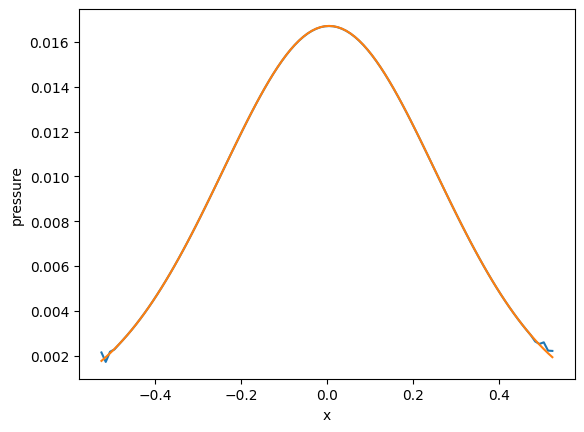

In [56]:
idx = -1

raw_data = np.loadtxt("GRHayL_NRPy_IGM_Ccodes/output/out106__read-00000010.txt")
plt.plot(raw_data[:,3], raw_data[:, idx])

raw_data_init = np.loadtxt("GRHayL_NRPy_IGM_Ccodes/output/out106__read-00000000.txt")
plt.plot(raw_data_init[:,3], raw_data_init[:, idx])

plt.xlabel("x")
plt.ylabel("pressure")

plt.show()

In [49]:
ETK_raw_data = np.loadtxt("/home/terrence/Projects/ETK/ET_2023_03/Cactus/exe/IGM_TOV/illinoisgrmhd-grmhd_primitives_allbutbi.z.asc")

time = -0.02
idxs = np.where(np.round(ETK_raw_data[:, 8], decimals=2)==time)
plot_data_init = ETK_raw_data[idxs]

time = 0.1
idxs = np.where(np.round(ETK_raw_data[:, 8], decimals=5)==time)
plot_data = ETK_raw_data[idxs]

# t = 8
# x = 9
# IllinoisGRMHD::rho_b = 12
# IllinoisGRMHD::P = 13, etc
# IllinoisGRMHD::vx
# IllinoisGRMHD::vy
# IllinoisGRMHD::vz

plt.scatter(plot_data[:, 11], plot_data[:, 13], s=0.2, marker='o', label="ETK: t=0.02")
plt.scatter(raw_data[:,0], raw_data[:, idx], s=0.2, label="NRPy_GRHayL: t=0.02")
# plt.plot(plot_data_init[:, 11], plot_data_init[:, 12], '--', label="ETK: t=0.0", color="black")
# plt.plot(raw_data_init[:,0], raw_data_init[:, idx], '-.', label="NRPy_GRHayL: t=0.0", color="r")
plt.legend()
# plt.xlim(-0.1, 0.1)
plt.xlabel("z")
plt.ylabel(r"pressure")
# plt.ylim(0,2)
plt.show()

FileNotFoundError: /home/terrence/Projects/ETK/ET_2023_03/Cactus/exe/IGM_TOV/illinoisgrmhd-grmhd_primitives_allbutbi.z.asc not found.

In [ ]:
plt.rcParams['figure.facecolor'] = 'white'

# raw_data[1:,0] - plot_data[:, 9]
# E_rel_diff_init = np.log10(0.5*np.abs((raw_data[:,-1] - plot_data[:, 13]) / ((raw_data[:,-1] + plot_data[:, 13]))))
# raw_data_saved = raw_data.copy()
E_rel_diff = np.log10(0.5*np.abs((raw_data[:,-1] - plot_data[:, 13]) / ((raw_data[:,-1] + plot_data[:, 13]))))

plt.plot(raw_data_saved[:,0], E_rel_diff_init + 2*np.log10(0.5), label="Nxx0 = 50, resc., 2ndO conv. ")
plt.plot(raw_data_saved[:,0], E_rel_diff_init + 4*np.log10(0.5), label="Nxx0 = 50, resc., 4thO conv. ")
plt.plot(raw_data[:,0], E_rel_diff, label="Nxx0 = 100")
# plt.plot(raw_data_init[:,0], test)
plt.ylabel("log10 Relative Diff.")
plt.xlabel("x")
plt.title("Error in Pressure after 10/20 (t=0.1) interations")
plt.legend()
# plt.savefig("test.fig", facecolor='white')
# plt.rcParams["figure.facecolor"] = "w"

# plt.xlim(-.2, .2)
plt.show()

<a id='convergence'></a>

# Step 4: Code validation: Plot the numerical error, and confirm that it converges to zero at expected rate with increasing numerical resolution (sampling) \[Back to [top](#toc)\]
$$\label{convergence}$$
The numerical solution $u_{\rm num}(x0,x1,x2,t)$ should converge to the exact solution $u_{\rm exact}(x0,x1,x2,t)$ at fourth order, which means that
$$
u_{\rm num}(x0,x1,x2,t) = u_{\rm exact}(x0,x1,x2,t) + \mathcal{O}\left((\Delta x0)^4\right)+ \mathcal{O}\left((\Delta x1)^4\right)+ \mathcal{O}\left((\Delta x2)^4\right)+ \mathcal{O}\left((\Delta t)^4\right).
$$

Thus the relative error $E_{\rm rel}$ should satisfy:
$$
\left|\frac{u_{\rm num}(x0,x1,x2,t) - u_{\rm exact}(x0,x1,x2,t)}{u_{\rm exact}(x0,x1,x2,t)}\right| + \mathcal{O}\left((\Delta x0)^4\right)+ \mathcal{O}\left((\Delta x1)^4\right)+ \mathcal{O}\left((\Delta x2)^4\right)+ \mathcal{O}\left((\Delta t)^4\right).
$$

We confirm this convergence behavior by first solving the scalar wave equation at two resolutions: $16\times 8\times 16$ (or $16^3$ if `reference_metric::CoordSystem` is set to `Cartesian`), and $24\times 12\times 24$ (or $24^3$ if `reference_metric::CoordSystem` is set to `Cartesian`) and evaluating the maximum logarithmic relative error $\log_{10} E_{\rm rel,max}$ between numerical and exact solutions within a region $R < 0.1 {\rm RMAX}$ at all iterations. 

Since we increase the resolution uniformly over all four coordinates $(x0,x1,x2,t)$, $E_{\rm rel}$ should drop uniformly as $(\Delta x0)^4$:
$$
E_{\rm rel} \propto (\Delta x0)^4.
$$

So at the two resolutions, we should find that
$$
\frac{E_{\rm rel}(16\times 8\times 16)}{E_{\rm rel}(24\times 12\times 24)} = \frac{E_{\rm rel}(16^3)}{E_{\rm rel}(24^3)} \approx \left(\frac{(\Delta x0)_{16}}{(\Delta x0)_{24}}\right)^{4} = \left(\frac{24}{16}\right)^4 \approx 5.
$$

Since we're measuring logarithmic relative error, this should be
$$
\log_{10}\left(\frac{E_{\rm rel}(16\times 8\times 16)}{E_{\rm rel}(24\times 12\times 24)}\right) = \log_{10}\left(\frac{E_{\rm rel}(16^3)}{E_{\rm rel}(24^3)}\right) \approx \log_{10}(5).
$$

<a id='latex_pdf_output'></a>

# Step 5: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-ScalarWaveCurvilinear.pdf](Tutorial-Start_to_Finish-ScalarWaveCurvilinear.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [ ]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Start_to_Finish-ScalarWaveCurvilinear")